# HNN EU Data New Hemisphere Optimized

In [2]:
# Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
#from torch.autograd import Variable
#from torchsummary import summary
#import torch.utils.data as Data

import optuna

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import scale
from statsmodels.tsa.stattools import adfuller

import copy
import itertools
import os
import time
import random
import math
import warnings
import sys

sys.path.append('../src/data/')

# Import HNN and tools functions
from HNN import HNN
import TrainHNN as TrainHNN
import DataProcessing as DataTools

# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

pd.set_option('display.max_columns', 2000) 

In [4]:
inflation = pd.read_excel('../data/raw/MAIN_DATABASE.xlsx', index_col=0, sheet_name='1.Inflation')
activity = pd.read_excel('../data/raw/MAIN_DATABASE.xlsx', index_col=0, sheet_name='2.Real activity')
external = pd.read_excel('../data/raw/MAIN_DATABASE.xlsx', index_col=0, sheet_name='3.External')
expectations = pd.read_excel('../data/raw/MAIN_DATABASE.xlsx', index_col=0, sheet_name='5.Expectations')
spillover = pd.read_csv('../data/raw/core_cpi.csv', index_col=0)
spillover

,core_cpi_us,core_cpi_ch
Date,,
1999-01-01,0.553118,-0.499611
1999-04-01,0.531108,-1.302090
1999-07-01,0.320755,2.317044
1999-10-01,0.601843,-0.097241
2000-01-01,0.729108,-1.388888
...,...,...
2017-01-01,0.660398,-0.300000
2017-04-01,0.395340,-0.200000
2017-07-01,0.244344,0.500000


In [5]:
# drop the first row of the spillover data and deduct 1 day from all the dates
spillover = spillover.iloc[1:]
spillover.index = pd.to_datetime(spillover.index) - pd.DateOffset(1)
spillover

,core_cpi_us,core_cpi_ch
Date,,
1999-03-31,0.531108,-1.302090
1999-06-30,0.320755,2.317044
1999-09-30,0.601843,-0.097241
1999-12-31,0.729108,-1.388888
2000-03-31,0.742390,-0.907692
...,...,...
2016-12-31,0.660398,-0.300000
2017-03-31,0.395340,-0.200000
2017-06-30,0.244344,0.500000


In [6]:
inflation = inflation.iloc[1:-1,:]
activity = activity.iloc[1:-1,:]
external = external.iloc[1:-1,:]
expectations = expectations.iloc[1:-1,:]
inflation

,HICPxEN_SA,HICPxENFOOD_SA
1999-03-31,89.14290,90.10781
1999-06-30,89.26107,90.24440
1999-09-30,89.45457,90.60880
1999-12-31,89.67210,90.66729
2000-03-31,89.88590,90.99102
...,...,...
2016-12-31,117.52750,115.29530
2017-03-31,117.96370,115.54440
2017-06-30,118.33870,116.00980
2017-09-30,118.70470,116.36170


In [7]:
# take the 1st difference
activity = activity.diff()
external = external.diff()
expectations = expectations.diff()
expectations

,SPF_2Y,SPF_1Y,Consensus_1Q,Consensus_2Q,Consensus_3Q,Consensus_1Y,Eurobarometer_1Q,Eurobarometer_2Q,Eurobarometer_3Q,Eurobarometer_1Y,BLOOMBERG_1Y1Y,SPF_Cons,SPF_Eurob,SPF_Bloom,Cons_Eurob,Cons_Bloom,Eurob_Bloom,SPF_Cons_Eurob,SPF_Cons_Bloom,SPF_Eurob_Bloom,Cons_Euro_Bloom,SPF_Cons_Eurob_Bloom,ECBILS1Y,ECBILS1Y1Y,ECBILS2Y,ConsumerEC
1999-03-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1999-06-30,0.155981,0.308093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,0.308093,NaN,NaN,NaN,9.916552
1999-09-30,0.014123,0.031301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,0.031301,NaN,NaN,NaN,-0.904060
1999-12-31,0.034991,0.026357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,0.026357,NaN,NaN,NaN,1.269241
2000-03-31,0.002467,0.116196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,0.116196,NaN,NaN,NaN,5.303978
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31,-0.011691,0.071595,0.5,-0.1,0.0,0.0,0.6,0.0,0.1,0.1,0.230922,0.094319,0.085798,0.151258,0.05,0.115461,0.165461,0.141288,0.100839,0.134172,0.171820,0.150252,0.194013,0.222352,0.208221,0.600816
2017-03-31,0.084926,0.167941,0.5,0.4,0.2,0.0,0.4,0.4,0.1,0.0,0.236994,0.253588,0.083970,0.202467,0.00,0.118497,0.118497,0.240882,0.134978,0.134978,0.189499,0.240493,0.316192,0.242103,0.279115,9.974822
2017-06-30,0.101859,0.102605,-0.2,-0.1,-0.3,0.1,-0.2,-0.3,-0.2,0.0,-0.011308,-0.079479,0.051303,0.045649,0.05,0.044346,-0.005654,-0.121933,0.063766,0.030433,-0.101885,-0.110870,-0.293423,-0.007151,-0.150307,-0.285561
2017-09-30,0.002263,-0.028594,-0.1,-0.4,0.1,0.0,-0.2,-0.2,0.1,0.1,0.112417,-0.085719,0.035703,0.041911,0.05,0.056208,0.106208,-0.069844,0.027941,0.061274,-0.014597,-0.051618,0.133385,0.110731,0.122038,-2.205786


In [8]:
inflation['Log_CPI'] = np.log(inflation['HICPxEN_SA'])

inflation['y'] = inflation['Log_CPI'].diff()

inflation

,HICPxEN_SA,HICPxENFOOD_SA,Log_CPI,y
1999-03-31,89.14290,90.10781,4.490241,NaN
1999-06-30,89.26107,90.24440,4.491565,0.001325
1999-09-30,89.45457,90.60880,4.493731,0.002165
1999-12-31,89.67210,90.66729,4.496160,0.002429
2000-03-31,89.88590,90.99102,4.498541,0.002381
...,...,...,...,...
2016-12-31,117.52750,115.29530,4.766672,0.002216
2017-03-31,117.96370,115.54440,4.770377,0.003705
2017-06-30,118.33870,116.00980,4.773551,0.003174
2017-09-30,118.70470,116.36170,4.776639,0.003088


In [9]:
data = pd.concat([inflation, activity, external, expectations, spillover], axis=1, join='inner')
data

,HICPxEN_SA,HICPxENFOOD_SA,Log_CPI,y,RealGDP,UR,OutputGap,UnemplGap,AVGDGP,AVGDGT,RecessionGap,ULCindx,IMFWEOgap,ECBJLgap,NAIRU,U6,EUR_USD,OILSDW,NEER,NonenComEUR,DG_AGRI,SDWimpdef,NonEnComUSD,SPF_2Y,SPF_1Y,Consensus_1Q,Consensus_2Q,Consensus_3Q,Consensus_1Y,Eurobarometer_1Q,Eurobarometer_2Q,Eurobarometer_3Q,Eurobarometer_1Y,BLOOMBERG_1Y1Y,SPF_Cons,SPF_Eurob,SPF_Bloom,Cons_Eurob,Cons_Bloom,Eurob_Bloom,SPF_Cons_Eurob,SPF_Cons_Bloom,SPF_Eurob_Bloom,Cons_Euro_Bloom,SPF_Cons_Eurob_Bloom,ECBILS1Y,ECBILS1Y1Y,ECBILS2Y,ConsumerEC,core_cpi_us,core_cpi_ch
1999-03-31,89.14290,90.10781,4.490241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.531108,-1.302090
1999-06-30,89.26107,90.24440,4.491565,0.001325,13595.663503,-0.13,0.124130,-0.102900,0.363011,0.389807,0.0,0.586015,0.34650,0.5036,-0.027100,-0.162720,-0.064702,4.257612,-3.759416,4.835160,1.237851,0.849629,0.947244,0.155981,0.308093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,0.308093,NaN,NaN,NaN,9.916552,0.320755,2.317044
1999-09-30,89.45457,90.60880,4.493731,0.002165,22450.074173,-0.16,0.553280,-0.130600,0.363011,0.389807,0.0,0.043493,0.34650,0.5843,-0.029400,-0.174285,-0.008346,4.986084,-0.697594,1.170416,1.248476,1.325308,0.649926,0.014123,0.031301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,0.031301,NaN,NaN,NaN,-0.904060,0.601843,-0.097241
1999-12-31,89.67210,90.66729,4.496160,0.002429,26013.562850,-0.18,0.722100,-0.147700,0.363011,0.389807,0.0,-0.061529,0.34650,0.6457,-0.032300,-0.195099,-0.010571,3.591333,-1.168472,4.309407,0.008160,1.415755,3.729474,0.034991,0.026357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,0.026357,NaN,NaN,NaN,1.269241,0.729108,-1.388888
2000-03-31,89.88590,90.99102,4.498541,0.002381,23372.194103,-0.26,0.567400,-0.204000,0.363011,0.389807,0.0,0.201527,0.34650,0.4828,-0.056000,-0.305601,-0.051543,4.118256,-3.376296,8.650421,2.821986,2.346283,4.685144,0.002467,0.116196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,0.116196,NaN,NaN,NaN,5.303978,0.742390,-0.907692
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31,117.52750,115.29530,4.766672,0.002216,16272.727079,-0.20,0.335900,-0.160300,0.208472,0.178433,0.0,0.219199,0.19675,0.1095,-0.039700,-0.284444,-0.037683,5.485081,-0.504077,5.599600,6.641109,1.218879,1.988440,-0.011691,0.071595,0.5,-0.1,0.0,0.0,0.6,0.0,0.1,0.1,0.230922,0.094319,0.085798,0.151258,0.05,0.115461,0.165461,0.141288,0.100839,0.134172,0.171820,0.150252,0.194013,0.222352,0.208221,0.600816,0.660398,-0.300000
2017-03-31,117.96370,115.54440,4.770377,0.003705,15969.817195,-0.26,0.300500,-0.237799,0.208472,0.178433,0.0,0.221774,0.19675,0.2338,-0.022201,-0.365158,-0.014148,4.271571,-0.844263,8.139875,2.537293,2.159087,7.066293,0.084926,0.167941,0.5,0.4,0.2,0.0,0.4,0.4,0.1,0.0,0.236994,0.253588,0.083970,0.202467,0.00,0.118497,0.118497,0.240882,0.134978,0.134978,0.189499,0.240493,0.316192,0.242103,0.279115,9.974822,0.395340,-0.200000
2017-06-30,118.33870,116.00980,4.773551,0.003174,18735.004773,-0.33,0.385830,-0.289100,0.158094,0.119892,0.0,0.056129,0.12925,0.1221,-0.040900,-0.373104,0.037334,-5.146301,1.578639,-8.484352,1.496349,-0.962554,-4.822315,0.101859,0.102605,-0.2,-0.1,-0.3,0.1,-0.2,-0.3,-0.2,0.0,-0.011308,-0.079479,0.051303,0.045649,0.05,0.044346,-0.005654,-0.121933,0.063766,0.030433,-0.101885,-0.110870,-0.293423,-0.007151,-0.150307,-0.285561,0.244344,0.500000
2017-09-30,118.70470,116.36170,4.776639,0.003088,17585.516756,-0.19,0.358470,-0.164900,0.158094,0.119892,0.0,0.145159,0.12925,0.2304,-0.025100

In [10]:
# remove 1st row
data = data.iloc[1:,:]
data

,HICPxEN_SA,HICPxENFOOD_SA,Log_CPI,y,RealGDP,UR,OutputGap,UnemplGap,AVGDGP,AVGDGT,RecessionGap,ULCindx,IMFWEOgap,ECBJLgap,NAIRU,U6,EUR_USD,OILSDW,NEER,NonenComEUR,DG_AGRI,SDWimpdef,NonEnComUSD,SPF_2Y,SPF_1Y,Consensus_1Q,Consensus_2Q,Consensus_3Q,Consensus_1Y,Eurobarometer_1Q,Eurobarometer_2Q,Eurobarometer_3Q,Eurobarometer_1Y,BLOOMBERG_1Y1Y,SPF_Cons,SPF_Eurob,SPF_Bloom,Cons_Eurob,Cons_Bloom,Eurob_Bloom,SPF_Cons_Eurob,SPF_Cons_Bloom,SPF_Eurob_Bloom,Cons_Euro_Bloom,SPF_Cons_Eurob_Bloom,ECBILS1Y,ECBILS1Y1Y,ECBILS2Y,ConsumerEC,core_cpi_us,core_cpi_ch
1999-06-30,89.26107,90.24440,4.491565,0.001325,13595.663503,-0.13,0.124130,-0.102900,0.363011,0.389807,0.0,0.586015,0.34650,0.5036,-0.027100,-0.162720,-0.064702,4.257612,-3.759416,4.835160,1.237851,0.849629,0.947244,0.155981,0.308093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,0.308093,NaN,NaN,NaN,9.916552,0.320755,2.317044
1999-09-30,89.45457,90.60880,4.493731,0.002165,22450.074173,-0.16,0.553280,-0.130600,0.363011,0.389807,0.0,0.043493,0.34650,0.5843,-0.029400,-0.174285,-0.008346,4.986084,-0.697594,1.170416,1.248476,1.325308,0.649926,0.014123,0.031301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,0.031301,NaN,NaN,NaN,-0.904060,0.601843,-0.097241
1999-12-31,89.67210,90.66729,4.496160,0.002429,26013.562850,-0.18,0.722100,-0.147700,0.363011,0.389807,0.0,-0.061529,0.34650,0.6457,-0.032300,-0.195099,-0.010571,3.591333,-1.168472,4.309407,0.008160,1.415755,3.729474,0.034991,0.026357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,0.026357,NaN,NaN,NaN,1.269241,0.729108,-1.388888
2000-03-31,89.88590,90.99102,4.498541,0.002381,23372.194103,-0.26,0.567400,-0.204000,0.363011,0.389807,0.0,0.201527,0.34650,0.4828,-0.056000,-0.305601,-0.051543,4.118256,-3.376296,8.650421,2.821986,2.346283,4.685144,0.002467,0.116196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,0.116196,NaN,NaN,NaN,5.303978,0.742390,-0.907692
2000-06-30,90.05369,91.06136,4.500406,0.001865,18749.009544,-0.23,0.364200,-0.201399,-0.020341,0.002490,0.0,0.144939,0.03575,0.3463,-0.028601,-0.262500,-0.053254,1.407823,-2.612603,1.954245,1.078176,1.196004,-2.612781,0.053530,0.069636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069636,0.069636,0.069636,NaN,NaN,NaN,0.069636,0.069636,0.069636,NaN,0.069636,NaN,NaN,NaN,-5.567286,0.460575,2.011011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-31,117.52750,115.29530,4.766672,0.002216,16272.727079,-0.20,0.335900,-0.160300,0.208472,0.178433,0.0,0.219199,0.19675,0.1095,-0.039700,-0.284444,-0.037683,5.485081,-0.504077,5.599600,6.641109,1.218879,1.988440,-0.011691,0.071595,0.5,-0.1,0.0,0.0,0.6,0.0,0.1,0.1,0.230922,0.094319,0.085798,0.151258,0.05,0.115461,0.165461,0.141288,0.100839,0.134172,0.171820,0.150252,0.194013,0.222352,0.208221,0.600816,0.660398,-0.300000
2017-03-31,117.96370,115.54440,4.770377,0.003705,15969.817195,-0.26,0.300500,-0.237799,0.208472,0.178433,0.0,0.221774,0.19675,0.2338,-0.022201,-0.365158,-0.014148,4.271571,-0.844263,8.139875,2.537293,2.159087,7.066293,0.084926,0.167941,0.5,0.4,0.2,0.0,0.4,0.4,0.1,0.0,0.236994,0.253588,0.083970,0.202467,0.00,0.118497,0.118497,0.240882,0.134978,0.134978,0.189499,0.240493,0.316192,0.242103,0.279115,9.974822,0.395340,-0.200000
2017-06-30,118.33870,116.00980,4.773551,0.003174,18735.004773,-0.33,0.385830,-0.289100,0.158094,0.119892,0.0,0.056129,0.12925,0.1221,-0.040900,-0.373104,0.037334,-5.146301,1.578639,-8.484352,1.496349,-0.962554,-4.822315,0.101859,0.102605,-0.2,-0.1,-0.3,0.1,-0.2,-0.3,-0.2,0.0,-0.011308,-0.079479,0.051303,0.045649,0.05,0.044346,-0.005654,-0.121933,0.063766,0.030433,-0.101885,-0.110870,-0.293423,-0.007151,-0.150307,-0.285561,0.244344,0

In [11]:
# rename index to date and make it a column
data = data.reset_index()
# rename index to date and make it the first column
data = data.rename(columns={'index':'date'})
data

,date,HICPxEN_SA,HICPxENFOOD_SA,Log_CPI,y,RealGDP,UR,OutputGap,UnemplGap,AVGDGP,AVGDGT,RecessionGap,ULCindx,IMFWEOgap,ECBJLgap,NAIRU,U6,EUR_USD,OILSDW,NEER,NonenComEUR,DG_AGRI,SDWimpdef,NonEnComUSD,SPF_2Y,SPF_1Y,Consensus_1Q,Consensus_2Q,Consensus_3Q,Consensus_1Y,Eurobarometer_1Q,Eurobarometer_2Q,Eurobarometer_3Q,Eurobarometer_1Y,BLOOMBERG_1Y1Y,SPF_Cons,SPF_Eurob,SPF_Bloom,Cons_Eurob,Cons_Bloom,Eurob_Bloom,SPF_Cons_Eurob,SPF_Cons_Bloom,SPF_Eurob_Bloom,Cons_Euro_Bloom,SPF_Cons_Eurob_Bloom,ECBILS1Y,ECBILS1Y1Y,ECBILS2Y,ConsumerEC,core_cpi_us,core_cpi_ch
0,1999-06-30,89.26107,90.24440,4.491565,0.001325,13595.663503,-0.13,0.124130,-0.102900,0.363011,0.389807,0.0,0.586015,0.34650,0.5036,-0.027100,-0.162720,-0.064702,4.257612,-3.759416,4.835160,1.237851,0.849629,0.947244,0.155981,0.308093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,0.308093,NaN,NaN,NaN,9.916552,0.320755,2.317044
1,1999-09-30,89.45457,90.60880,4.493731,0.002165,22450.074173,-0.16,0.553280,-0.130600,0.363011,0.389807,0.0,0.043493,0.34650,0.5843,-0.029400,-0.174285,-0.008346,4.986084,-0.697594,1.170416,1.248476,1.325308,0.649926,0.014123,0.031301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,0.031301,NaN,NaN,NaN,-0.904060,0.601843,-0.097241
2,1999-12-31,89.67210,90.66729,4.496160,0.002429,26013.562850,-0.18,0.722100,-0.147700,0.363011,0.389807,0.0,-0.061529,0.34650,0.6457,-0.032300,-0.195099,-0.010571,3.591333,-1.168472,4.309407,0.008160,1.415755,3.729474,0.034991,0.026357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,0.026357,NaN,NaN,NaN,1.269241,0.729108,-1.388888
3,2000-03-31,89.88590,90.99102,4.498541,0.002381,23372.194103,-0.26,0.567400,-0.204000,0.363011,0.389807,0.0,0.201527,0.34650,0.4828,-0.056000,-0.305601,-0.051543,4.118256,-3.376296,8.650421,2.821986,2.346283,4.685144,0.002467,0.116196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,0.116196,NaN,NaN,NaN,5.303978,0.742390,-0.907692
4,2000-06-30,90.05369,91.06136,4.500406,0.001865,18749.009544,-0.23,0.364200,-0.201399,-0.020341,0.002490,0.0,0.144939,0.03575,0.3463,-0.028601,-0.262500,-0.053254,1.407823,-2.612603,1.954245,1.078176,1.196004,-2.612781,0.053530,0.069636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069636,0.069636,0.069636,NaN,NaN,NaN,0.069636,0.069636,0.069636,NaN,0.069636,NaN,NaN,NaN,-5.567286,0.460575,2.011011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2016-12-31,117.52750,115.29530,4.766672,0.002216,16272.727079,-0.20,0.335900,-0.160300,0.208472,0.178433,0.0,0.219199,0.19675,0.1095,-0.039700,-0.284444,-0.037683,5.485081,-0.504077,5.599600,6.641109,1.218879,1.988440,-0.011691,0.071595,0.5,-0.1,0.0,0.0,0.6,0.0,0.1,0.1,0.230922,0.094319,0.085798,0.151258,0.05,0.115461,0.165461,0.141288,0.100839,0.134172,0.171820,0.150252,0.194013,0.222352,0.208221,0.600816,0.660398,-0.300000
71,2017-03-31,117.96370,115.54440,4.770377,0.003705,15969.817195,-0.26,0.300500,-0.237799,0.208472,0.178433,0.0,0.221774,0.19675,0.2338,-0.022201,-0.365158,-0.014148,4.271571,-0.844263,8.139875,2.537293,2.159087,7.066293,0.084926,0.167941,0.5,0.4,0.2,0.0,0.4,0.4,0.1,0.0,0.236994,0.253588,0.083970,0.202467,0.00,0.118497,0.118497,0.240882,0.134978,0.134978,0.189499,0.240493,0.316192,0.242103,0.279115,9.974822,0.395340,-0.200000
72,2017-06-30,118.33870,116.00980,4.773551,0.003174,18735.004773,-0.33,0.385830,-0.289100,0.158094,0.119892,0.0,0.056129,0.12925,0.1221,-0.040900,-0.373104,0.037334,-5.146301,1.578639,-8.484352,1.496349,-0.962554,-4.822315,0.101859,0.102605,-0.2,-0.1,-0.3,0.1,-0.2,-0.3,-0.2,0.0,-0.011308,-0.079479,0.051303,0.045649,0.05,0.044346,-0.005654,-0.121933,0.063766,0.030433,-0.101885,-0.110870,-0.293423,-0.007151,-0

In [12]:
# rename HICPxEN_SA to y
# data = data.rename(columns={'HICPxEN_SA':'y'})
# drop HICPxENFOOD_SA
data = data.drop(columns=['HICPxENFOOD_SA', 'HICPxEN_SA', 'Log_CPI'])
data

,date,y,RealGDP,UR,OutputGap,UnemplGap,AVGDGP,AVGDGT,RecessionGap,ULCindx,IMFWEOgap,ECBJLgap,NAIRU,U6,EUR_USD,OILSDW,NEER,NonenComEUR,DG_AGRI,SDWimpdef,NonEnComUSD,SPF_2Y,SPF_1Y,Consensus_1Q,Consensus_2Q,Consensus_3Q,Consensus_1Y,Eurobarometer_1Q,Eurobarometer_2Q,Eurobarometer_3Q,Eurobarometer_1Y,BLOOMBERG_1Y1Y,SPF_Cons,SPF_Eurob,SPF_Bloom,Cons_Eurob,Cons_Bloom,Eurob_Bloom,SPF_Cons_Eurob,SPF_Cons_Bloom,SPF_Eurob_Bloom,Cons_Euro_Bloom,SPF_Cons_Eurob_Bloom,ECBILS1Y,ECBILS1Y1Y,ECBILS2Y,ConsumerEC,core_cpi_us,core_cpi_ch
0,1999-06-30,0.001325,13595.663503,-0.13,0.124130,-0.102900,0.363011,0.389807,0.0,0.586015,0.34650,0.5036,-0.027100,-0.162720,-0.064702,4.257612,-3.759416,4.835160,1.237851,0.849629,0.947244,0.155981,0.308093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,0.308093,NaN,NaN,NaN,9.916552,0.320755,2.317044
1,1999-09-30,0.002165,22450.074173,-0.16,0.553280,-0.130600,0.363011,0.389807,0.0,0.043493,0.34650,0.5843,-0.029400,-0.174285,-0.008346,4.986084,-0.697594,1.170416,1.248476,1.325308,0.649926,0.014123,0.031301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,0.031301,NaN,NaN,NaN,-0.904060,0.601843,-0.097241
2,1999-12-31,0.002429,26013.562850,-0.18,0.722100,-0.147700,0.363011,0.389807,0.0,-0.061529,0.34650,0.6457,-0.032300,-0.195099,-0.010571,3.591333,-1.168472,4.309407,0.008160,1.415755,3.729474,0.034991,0.026357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,NaN,NaN,0.026357,0.026357,0.026357,NaN,0.026357,NaN,NaN,NaN,1.269241,0.729108,-1.388888
3,2000-03-31,0.002381,23372.194103,-0.26,0.567400,-0.204000,0.363011,0.389807,0.0,0.201527,0.34650,0.4828,-0.056000,-0.305601,-0.051543,4.118256,-3.376296,8.650421,2.821986,2.346283,4.685144,0.002467,0.116196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,NaN,NaN,0.116196,0.116196,0.116196,NaN,0.116196,NaN,NaN,NaN,5.303978,0.742390,-0.907692
4,2000-06-30,0.001865,18749.009544,-0.23,0.364200,-0.201399,-0.020341,0.002490,0.0,0.144939,0.03575,0.3463,-0.028601,-0.262500,-0.053254,1.407823,-2.612603,1.954245,1.078176,1.196004,-2.612781,0.053530,0.069636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069636,0.069636,0.069636,NaN,NaN,NaN,0.069636,0.069636,0.069636,NaN,0.069636,NaN,NaN,NaN,-5.567286,0.460575,2.011011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,2016-12-31,0.002216,16272.727079,-0.20,0.335900,-0.160300,0.208472,0.178433,0.0,0.219199,0.19675,0.1095,-0.039700,-0.284444,-0.037683,5.485081,-0.504077,5.599600,6.641109,1.218879,1.988440,-0.011691,0.071595,0.5,-0.1,0.0,0.0,0.6,0.0,0.1,0.1,0.230922,0.094319,0.085798,0.151258,0.05,0.115461,0.165461,0.141288,0.100839,0.134172,0.171820,0.150252,0.194013,0.222352,0.208221,0.600816,0.660398,-0.300000
71,2017-03-31,0.003705,15969.817195,-0.26,0.300500,-0.237799,0.208472,0.178433,0.0,0.221774,0.19675,0.2338,-0.022201,-0.365158,-0.014148,4.271571,-0.844263,8.139875,2.537293,2.159087,7.066293,0.084926,0.167941,0.5,0.4,0.2,0.0,0.4,0.4,0.1,0.0,0.236994,0.253588,0.083970,0.202467,0.00,0.118497,0.118497,0.240882,0.134978,0.134978,0.189499,0.240493,0.316192,0.242103,0.279115,9.974822,0.395340,-0.200000
72,2017-06-30,0.003174,18735.004773,-0.33,0.385830,-0.289100,0.158094,0.119892,0.0,0.056129,0.12925,0.1221,-0.040900,-0.373104,0.037334,-5.146301,1.578639,-8.484352,1.496349,-0.962554,-4.822315,0.101859,0.102605,-0.2,-0.1,-0.3,0.1,-0.2,-0.3,-0.2,0.0,-0.011308,-0.079479,0.051303,0.045649,0.05,0.044346,-0.005654,-0.121933,0.063766,0.030433,-0.101885,-0.110870,-0.293423,-0.007151,-0.150307,-0.285561,0.244344,0.500000
73,2017-09-30,0.003088,17585.516756,-0.19,0.358470,-0.164900,0.158094,0.119892,0.0,0.145159,0.12925,0.2304,-0.025100,-0.198133,0.072477,-1.658358,4.333281,-3.410087,3.729492,-0.382453,4.170970,0.002263,-0.028594,-0.1,-0.4,0.1,0.0,-0

In [13]:
def create_lagged_columns_v2(df, num_lags):
    """
    Create specified number of lagged columns for each variable in the DataFrame.
    For the variable named 'y', do not add 'L0_' prefix and use a different naming convention for lags.

    Parameters:
    df (pd.DataFrame): The original DataFrame with macroeconomic data.
    num_lags (int): The number of lagged columns to create.

    Returns:
    pd.DataFrame: A DataFrame with the original and lagged columns.
    """

    lagged_data_chunks = []

    for col in df.columns:
        if col != 'date':
            # For the 'y' variable, handle lag creation and naming differently
            if col == 'y':
                for lag in range(1, num_lags + 1):
                    lagged_data_chunks.append(df[col].shift(lag).rename(f"L_{lag - 1}y"))
            else:
                # Rename the macroeconomic variables with "L0_" and create lagged columns
                df = df.rename(columns={col: f"L0_{col}"})
                for lag in range(1, num_lags + 1):
                    lagged_data_chunks.append(df[f"L0_{col}"].shift(lag).rename(f"L{lag}_{col}"))

    df_final = pd.concat([df] + lagged_data_chunks, axis=1)

    return df_final

In [14]:
data1 = create_lagged_columns_v2(data, 3)
data1

,date,y,L0_RealGDP,L0_UR,L0_OutputGap,L0_UnemplGap,L0_AVGDGP,L0_AVGDGT,L0_RecessionGap,L0_ULCindx,L0_IMFWEOgap,L0_ECBJLgap,L0_NAIRU,L0_U6,L0_EUR_USD,L0_OILSDW,L0_NEER,L0_NonenComEUR,L0_DG_AGRI,L0_SDWimpdef,L0_NonEnComUSD,L0_SPF_2Y,L0_SPF_1Y,L0_Consensus_1Q,L0_Consensus_2Q,L0_Consensus_3Q,L0_Consensus_1Y,L0_Eurobarometer_1Q,L0_Eurobarometer_2Q,L0_Eurobarometer_3Q,L0_Eurobarometer_1Y,L0_BLOOMBERG_1Y1Y,L0_SPF_Cons,L0_SPF_Eurob,L0_SPF_Bloom,L0_Cons_Eurob,L0_Cons_Bloom,L0_Eurob_Bloom,L0_SPF_Cons_Eurob,L0_SPF_Cons_Bloom,L0_SPF_Eurob_Bloom,L0_Cons_Euro_Bloom,L0_SPF_Cons_Eurob_Bloom,L0_ECBILS1Y,L0_ECBILS1Y1Y,L0_ECBILS2Y,L0_ConsumerEC,L0_core_cpi_us,L0_core_cpi_ch,L_0y,L_1y,L_2y,L1_RealGDP,L2_RealGDP,L3_RealGDP,L1_UR,L2_UR,L3_UR,L1_OutputGap,L2_OutputGap,L3_OutputGap,L1_UnemplGap,L2_UnemplGap,L3_UnemplGap,L1_AVGDGP,L2_AVGDGP,L3_AVGDGP,L1_AVGDGT,L2_AVGDGT,L3_AVGDGT,L1_RecessionGap,L2_RecessionGap,L3_RecessionGap,L1_ULCindx,L2_ULCindx,L3_ULCindx,L1_IMFWEOgap,L2_IMFWEOgap,L3_IMFWEOgap,L1_ECBJLgap,L2_ECBJLgap,L3_ECBJLgap,L1_NAIRU,L2_NAIRU,L3_NAIRU,L1_U6,L2_U6,L3_U6,L1_EUR_USD,L2_EUR_USD,L3_EUR_USD,L1_OILSDW,L2_OILSDW,L3_OILSDW,L1_NEER,L2_NEER,L3_NEER,L1_NonenComEUR,L2_NonenComEUR,L3_NonenComEUR,L1_DG_AGRI,L2_DG_AGRI,L3_DG_AGRI,L1_SDWimpdef,L2_SDWimpdef,L3_SDWimpdef,L1_NonEnComUSD,L2_NonEnComUSD,L3_NonEnComUSD,L1_SPF_2Y,L2_SPF_2Y,L3_SPF_2Y,L1_SPF_1Y,L2_SPF_1Y,L3_SPF_1Y,L1_Consensus_1Q,L2_Consensus_1Q,L3_Consensus_1Q,L1_Consensus_2Q,L2_Consensus_2Q,L3_Consensus_2Q,L1_Consensus_3Q,L2_Consensus_3Q,L3_Consensus_3Q,L1_Consensus_1Y,L2_Consensus_1Y,L3_Consensus_1Y,L1_Eurobarometer_1Q,L2_Eurobarometer_1Q,L3_Eurobarometer_1Q,L1_Eurobarometer_2Q,L2_Eurobarometer_2Q,L3_Eurobarometer_2Q,L1_Eurobarometer_3Q,L2_Eurobarometer_3Q,L3_Eurobarometer_3Q,L1_Eurobarometer_1Y,L2_Eurobarometer_1Y,L3_Eurobarometer_1Y,L1_BLOOMBERG_1Y1Y,L2_BLOOMBERG_1Y1Y,L3_BLOOMBERG_1Y1Y,L1_SPF_Cons,L2_SPF_Cons,L3_SPF_Cons,L1_SPF_Eurob,L2_SPF_Eurob,L3_SPF_Eurob,L1_SPF_Bloom,L2_SPF_Bloom,L3_SPF_Bloom,L1_Cons_Eurob,L2_Cons_Eurob,L3_Cons_Eurob,L1_Cons_Bloom,L2_Cons_Bloom,L3_Cons_Bloom,L1_Eurob_Bloom,L2_Eurob_Bloom,L3_Eurob_Bloom,L1_SPF_Cons_Eurob,L2_SPF_Cons_Eurob,L3_SPF_Cons_Eurob,L1_SPF_Cons_Bloom,L2_SPF_Cons_Bloom,L3_SPF_Cons_Bloom,L1_SPF_Eurob_Bloom,L2_SPF_Eurob_Bloom,L3_SPF_Eurob_Bloom,L1_Cons_Euro_Bloom,L2_Cons_Euro_Bloom,L3_Cons_Euro_Bloom,L1_SPF_Cons_Eurob_Bloom,L2_SPF_Cons_Eurob_Bloom,L3_SPF_Cons_Eurob_Bloom,L1_ECBILS1Y,L2_ECBILS1Y,L3_ECBILS1Y,L1_ECBILS1Y1Y,L2_ECBILS1Y1Y,L3_ECBILS1Y1Y,L1_ECBILS2Y,L2_ECBILS2Y,L3_ECBILS2Y,L1_ConsumerEC,L2_ConsumerEC,L3_ConsumerEC,L1_core_cpi_us,L2_core_cpi_us,L3_core_cpi_us,L1_core_cpi_ch,L2_core_cpi_ch,L3_core_cpi_ch
0,1999-06-30,0.001325,13595.663503,-0.13,0.124130,-0.102900,0.363011,0.389807,0.0,0.586015,0.34650,0.5036,-0.027100,-0.162720,-0.064702,4.257612,-3.759416,4.835160,1.237851,0.849629,0.947244,0.155981,0.308093,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,NaN,NaN,0.308093,0.308093,0.308093,NaN,0.308093,NaN,NaN,NaN,9.916552,0.320755,2.317044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1999-09-30,0.002165,22450.074173,-0.16,0.553280,-0.130600,0.363011,0.389807,0.0,0.043493,0.34650,0.5843,-0.029400,-0.174285,-0.008346,4.986084,-0.697594,1.170416,1.248476,1.325308,0.649926,0.014123,0.031301,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,NaN,NaN,0.031301,0.031301,0.031301,NaN,0.031301,NaN,NaN,NaN,-0.904060,0.601843,-0.097241,0.001325,NaN,NaN,13595.663503,NaN,NaN,-0.13,NaN,N

In [15]:
def calculate_selected_marx(data):
    """
    Calculate L1_MARX and L3_MARX values for the first lagged column of each macroeconomic variable in the dataset.

    :param data: DataFrame containing the data with lagged variables.
    :return: DataFrame with calculated L1_MARX and L3_MARX values for each variable.
    """
    result = data.copy()

    # Extracting unique variable names from L0_ columns
    variable_names = [col.split('_', 1)[1] for col in data.columns if col.startswith('L0_')]

    for var in variable_names:
        result[f'L1_MARX_{var}'] = result[[f'L0_{var}', f'L1_{var}']].mean(axis=1)
        result[f'L3_MARX_{var}'] = result[[f'L0_{var}', f'L1_{var}', f'L2_{var}', f'L3_{var}']].mean(axis=1)

    return result

In [16]:
data2 = calculate_selected_marx(data1)
data2

,date,y,L0_RealGDP,L0_UR,L0_OutputGap,L0_UnemplGap,L0_AVGDGP,L0_AVGDGT,L0_RecessionGap,L0_ULCindx,L0_IMFWEOgap,L0_ECBJLgap,L0_NAIRU,L0_U6,L0_EUR_USD,L0_OILSDW,L0_NEER,L0_NonenComEUR,L0_DG_AGRI,L0_SDWimpdef,L0_NonEnComUSD,L0_SPF_2Y,L0_SPF_1Y,L0_Consensus_1Q,L0_Consensus_2Q,L0_Consensus_3Q,L0_Consensus_1Y,L0_Eurobarometer_1Q,L0_Eurobarometer_2Q,L0_Eurobarometer_3Q,L0_Eurobarometer_1Y,L0_BLOOMBERG_1Y1Y,L0_SPF_Cons,L0_SPF_Eurob,L0_SPF_Bloom,L0_Cons_Eurob,L0_Cons_Bloom,L0_Eurob_Bloom,L0_SPF_Cons_Eurob,L0_SPF_Cons_Bloom,L0_SPF_Eurob_Bloom,L0_Cons_Euro_Bloom,L0_SPF_Cons_Eurob_Bloom,L0_ECBILS1Y,L0_ECBILS1Y1Y,L0_ECBILS2Y,L0_ConsumerEC,L0_core_cpi_us,L0_core_cpi_ch,L_0y,L_1y,L_2y,L1_RealGDP,L2_RealGDP,L3_RealGDP,L1_UR,L2_UR,L3_UR,L1_OutputGap,L2_OutputGap,L3_OutputGap,L1_UnemplGap,L2_UnemplGap,L3_UnemplGap,L1_AVGDGP,L2_AVGDGP,L3_AVGDGP,L1_AVGDGT,L2_AVGDGT,L3_AVGDGT,L1_RecessionGap,L2_RecessionGap,L3_RecessionGap,L1_ULCindx,L2_ULCindx,L3_ULCindx,L1_IMFWEOgap,L2_IMFWEOgap,L3_IMFWEOgap,L1_ECBJLgap,L2_ECBJLgap,L3_ECBJLgap,L1_NAIRU,L2_NAIRU,L3_NAIRU,L1_U6,L2_U6,L3_U6,L1_EUR_USD,L2_EUR_USD,L3_EUR_USD,L1_OILSDW,L2_OILSDW,L3_OILSDW,L1_NEER,L2_NEER,L3_NEER,L1_NonenComEUR,L2_NonenComEUR,L3_NonenComEUR,L1_DG_AGRI,L2_DG_AGRI,L3_DG_AGRI,L1_SDWimpdef,L2_SDWimpdef,L3_SDWimpdef,L1_NonEnComUSD,L2_NonEnComUSD,L3_NonEnComUSD,L1_SPF_2Y,L2_SPF_2Y,L3_SPF_2Y,L1_SPF_1Y,L2_SPF_1Y,L3_SPF_1Y,L1_Consensus_1Q,L2_Consensus_1Q,L3_Consensus_1Q,L1_Consensus_2Q,L2_Consensus_2Q,L3_Consensus_2Q,L1_Consensus_3Q,L2_Consensus_3Q,L3_Consensus_3Q,L1_Consensus_1Y,L2_Consensus_1Y,L3_Consensus_1Y,L1_Eurobarometer_1Q,L2_Eurobarometer_1Q,L3_Eurobarometer_1Q,L1_Eurobarometer_2Q,L2_Eurobarometer_2Q,L3_Eurobarometer_2Q,L1_Eurobarometer_3Q,L2_Eurobarometer_3Q,L3_Eurobarometer_3Q,L1_Eurobarometer_1Y,L2_Eurobarometer_1Y,L3_Eurobarometer_1Y,L1_BLOOMBERG_1Y1Y,L2_BLOOMBERG_1Y1Y,L3_BLOOMBERG_1Y1Y,L1_SPF_Cons,L2_SPF_Cons,L3_SPF_Cons,L1_SPF_Eurob,L2_SPF_Eurob,L3_SPF_Eurob,L1_SPF_Bloom,L2_SPF_Bloom,L3_SPF_Bloom,L1_Cons_Eurob,L2_Cons_Eurob,L3_Cons_Eurob,L1_Cons_Bloom,L2_Cons_Bloom,L3_Cons_Bloom,L1_Eurob_Bloom,L2_Eurob_Bloom,L3_Eurob_Bloom,L1_SPF_Cons_Eurob,L2_SPF_Cons_Eurob,L3_SPF_Cons_Eurob,L1_SPF_Cons_Bloom,L2_SPF_Cons_Bloom,L3_SPF_Cons_Bloom,L1_SPF_Eurob_Bloom,L2_SPF_Eurob_Bloom,L3_SPF_Eurob_Bloom,L1_Cons_Euro_Bloom,L2_Cons_Euro_Bloom,L3_Cons_Euro_Bloom,L1_SPF_Cons_Eurob_Bloom,L2_SPF_Cons_Eurob_Bloom,L3_SPF_Cons_Eurob_Bloom,L1_ECBILS1Y,L2_ECBILS1Y,L3_ECBILS1Y,L1_ECBILS1Y1Y,L2_ECBILS1Y1Y,L3_ECBILS1Y1Y,L1_ECBILS2Y,L2_ECBILS2Y,L3_ECBILS2Y,L1_ConsumerEC,L2_ConsumerEC,L3_ConsumerEC,L1_core_cpi_us,L2_core_cpi_us,L3_core_cpi_us,L1_core_cpi_ch,L2_core_cpi_ch,L3_core_cpi_ch,L1_MARX_RealGDP,L3_MARX_RealGDP,L1_MARX_UR,L3_MARX_UR,L1_MARX_OutputGap,L3_MARX_OutputGap,L1_MARX_UnemplGap,L3_MARX_UnemplGap,L1_MARX_AVGDGP,L3_MARX_AVGDGP,L1_MARX_AVGDGT,L3_MARX_AVGDGT,L1_MARX_RecessionGap,L3_MARX_RecessionGap,L1_MARX_ULCindx,L3_MARX_ULCindx,L1_MARX_IMFWEOgap,L3_MARX_IMFWEOgap,L1_MARX_ECBJLgap,L3_MARX_ECBJLgap,L1_MARX_NAIRU,L3_MARX_NAIRU,L1_MARX_U6,L3_MARX_U6,L1_MARX_EUR_USD,L3_MARX_EUR_USD,L1_MARX_OILSDW,L3_MARX_OILSDW,L1_MARX_NEER,L3_MARX_NEER,L1_MARX_NonenComEUR,L3_MARX_NonenComEUR,L1_MARX_DG_AGRI,L3_MARX_DG_AGRI,L1_MARX_SDWimpdef,L3_MARX_SDWimpdef,L1_MARX_NonEnComUSD,L3_MARX_NonEnComUSD,L1_MARX_SPF_2Y,L3_MARX_SPF_2Y,L1_MARX_SPF_1Y,L3_MARX_SPF_1Y,L1_MARX_Consensus_1Q,L3_MARX_Consensus_1Q,L1_MARX_Consensus_2Q,L3_MARX_Consensus_2Q,L1_MARX_Consensus_3Q,L3_MARX_Consensus_3Q,L1_MARX_Consensus_1Y,L3_MARX_Consensus_1Y,L1_MARX_Eurobarometer_1Q,L3_MARX_Eurobarometer_1Q,L1_MARX_Eurobarometer_2Q,L3_MARX_Eurobarometer_2Q,L1_MARX_Eurobarometer_3Q,L3_MARX_Eurobarometer_3Q,L1_MARX_Eurobarometer_1Y,L3_MARX_Eurobarometer_1Y,L1_MARX_BLOOMBERG_1Y1Y,L3_MARX_BLOOMBERG_1Y1Y,L1_MARX_SPF_Cons,L3_MARX_SPF_Cons,L1_MARX_SPF_Eurob,L3_MARX_SPF_Eurob,L1_MARX_SPF_Bloom,L3_MARX_SPF_Bloom,L1_MARX_Cons_Eurob,L3_MARX_Cons_Eurob,L1_MARX_Cons_Bloom,L3_MARX_Cons_Bloom,L1_MARX_Eurob_Bloom,L3_MARX_Eurob_Bloom,L1_MARX_SPF_Cons_Eurob,L3_MARX_SPF_Cons_E

In [17]:
# remove the first 3 rows
data2 = data2.iloc[3:,:]
data2

,date,y,L0_RealGDP,L0_UR,L0_OutputGap,L0_UnemplGap,L0_AVGDGP,L0_AVGDGT,L0_RecessionGap,L0_ULCindx,L0_IMFWEOgap,L0_ECBJLgap,L0_NAIRU,L0_U6,L0_EUR_USD,L0_OILSDW,L0_NEER,L0_NonenComEUR,L0_DG_AGRI,L0_SDWimpdef,L0_NonEnComUSD,L0_SPF_2Y,L0_SPF_1Y,L0_Consensus_1Q,L0_Consensus_2Q,L0_Consensus_3Q,L0_Consensus_1Y,L0_Eurobarometer_1Q,L0_Eurobarometer_2Q,L0_Eurobarometer_3Q,L0_Eurobarometer_1Y,L0_BLOOMBERG_1Y1Y,L0_SPF_Cons,L0_SPF_Eurob,L0_SPF_Bloom,L0_Cons_Eurob,L0_Cons_Bloom,L0_Eurob_Bloom,L0_SPF_Cons_Eurob,L0_SPF_Cons_Bloom,L0_SPF_Eurob_Bloom,L0_Cons_Euro_Bloom,L0_SPF_Cons_Eurob_Bloom,L0_ECBILS1Y,L0_ECBILS1Y1Y,L0_ECBILS2Y,L0_ConsumerEC,L0_core_cpi_us,L0_core_cpi_ch,L_0y,L_1y,L_2y,L1_RealGDP,L2_RealGDP,L3_RealGDP,L1_UR,L2_UR,L3_UR,L1_OutputGap,L2_OutputGap,L3_OutputGap,L1_UnemplGap,L2_UnemplGap,L3_UnemplGap,L1_AVGDGP,L2_AVGDGP,L3_AVGDGP,L1_AVGDGT,L2_AVGDGT,L3_AVGDGT,L1_RecessionGap,L2_RecessionGap,L3_RecessionGap,L1_ULCindx,L2_ULCindx,L3_ULCindx,L1_IMFWEOgap,L2_IMFWEOgap,L3_IMFWEOgap,L1_ECBJLgap,L2_ECBJLgap,L3_ECBJLgap,L1_NAIRU,L2_NAIRU,L3_NAIRU,L1_U6,L2_U6,L3_U6,L1_EUR_USD,L2_EUR_USD,L3_EUR_USD,L1_OILSDW,L2_OILSDW,L3_OILSDW,L1_NEER,L2_NEER,L3_NEER,L1_NonenComEUR,L2_NonenComEUR,L3_NonenComEUR,L1_DG_AGRI,L2_DG_AGRI,L3_DG_AGRI,L1_SDWimpdef,L2_SDWimpdef,L3_SDWimpdef,L1_NonEnComUSD,L2_NonEnComUSD,L3_NonEnComUSD,L1_SPF_2Y,L2_SPF_2Y,L3_SPF_2Y,L1_SPF_1Y,L2_SPF_1Y,L3_SPF_1Y,L1_Consensus_1Q,L2_Consensus_1Q,L3_Consensus_1Q,L1_Consensus_2Q,L2_Consensus_2Q,L3_Consensus_2Q,L1_Consensus_3Q,L2_Consensus_3Q,L3_Consensus_3Q,L1_Consensus_1Y,L2_Consensus_1Y,L3_Consensus_1Y,L1_Eurobarometer_1Q,L2_Eurobarometer_1Q,L3_Eurobarometer_1Q,L1_Eurobarometer_2Q,L2_Eurobarometer_2Q,L3_Eurobarometer_2Q,L1_Eurobarometer_3Q,L2_Eurobarometer_3Q,L3_Eurobarometer_3Q,L1_Eurobarometer_1Y,L2_Eurobarometer_1Y,L3_Eurobarometer_1Y,L1_BLOOMBERG_1Y1Y,L2_BLOOMBERG_1Y1Y,L3_BLOOMBERG_1Y1Y,L1_SPF_Cons,L2_SPF_Cons,L3_SPF_Cons,L1_SPF_Eurob,L2_SPF_Eurob,L3_SPF_Eurob,L1_SPF_Bloom,L2_SPF_Bloom,L3_SPF_Bloom,L1_Cons_Eurob,L2_Cons_Eurob,L3_Cons_Eurob,L1_Cons_Bloom,L2_Cons_Bloom,L3_Cons_Bloom,L1_Eurob_Bloom,L2_Eurob_Bloom,L3_Eurob_Bloom,L1_SPF_Cons_Eurob,L2_SPF_Cons_Eurob,L3_SPF_Cons_Eurob,L1_SPF_Cons_Bloom,L2_SPF_Cons_Bloom,L3_SPF_Cons_Bloom,L1_SPF_Eurob_Bloom,L2_SPF_Eurob_Bloom,L3_SPF_Eurob_Bloom,L1_Cons_Euro_Bloom,L2_Cons_Euro_Bloom,L3_Cons_Euro_Bloom,L1_SPF_Cons_Eurob_Bloom,L2_SPF_Cons_Eurob_Bloom,L3_SPF_Cons_Eurob_Bloom,L1_ECBILS1Y,L2_ECBILS1Y,L3_ECBILS1Y,L1_ECBILS1Y1Y,L2_ECBILS1Y1Y,L3_ECBILS1Y1Y,L1_ECBILS2Y,L2_ECBILS2Y,L3_ECBILS2Y,L1_ConsumerEC,L2_ConsumerEC,L3_ConsumerEC,L1_core_cpi_us,L2_core_cpi_us,L3_core_cpi_us,L1_core_cpi_ch,L2_core_cpi_ch,L3_core_cpi_ch,L1_MARX_RealGDP,L3_MARX_RealGDP,L1_MARX_UR,L3_MARX_UR,L1_MARX_OutputGap,L3_MARX_OutputGap,L1_MARX_UnemplGap,L3_MARX_UnemplGap,L1_MARX_AVGDGP,L3_MARX_AVGDGP,L1_MARX_AVGDGT,L3_MARX_AVGDGT,L1_MARX_RecessionGap,L3_MARX_RecessionGap,L1_MARX_ULCindx,L3_MARX_ULCindx,L1_MARX_IMFWEOgap,L3_MARX_IMFWEOgap,L1_MARX_ECBJLgap,L3_MARX_ECBJLgap,L1_MARX_NAIRU,L3_MARX_NAIRU,L1_MARX_U6,L3_MARX_U6,L1_MARX_EUR_USD,L3_MARX_EUR_USD,L1_MARX_OILSDW,L3_MARX_OILSDW,L1_MARX_NEER,L3_MARX_NEER,L1_MARX_NonenComEUR,L3_MARX_NonenComEUR,L1_MARX_DG_AGRI,L3_MARX_DG_AGRI,L1_MARX_SDWimpdef,L3_MARX_SDWimpdef,L1_MARX_NonEnComUSD,L3_MARX_NonEnComUSD,L1_MARX_SPF_2Y,L3_MARX_SPF_2Y,L1_MARX_SPF_1Y,L3_MARX_SPF_1Y,L1_MARX_Consensus_1Q,L3_MARX_Consensus_1Q,L1_MARX_Consensus_2Q,L3_MARX_Consensus_2Q,L1_MARX_Consensus_3Q,L3_MARX_Consensus_3Q,L1_MARX_Consensus_1Y,L3_MARX_Consensus_1Y,L1_MARX_Eurobarometer_1Q,L3_MARX_Eurobarometer_1Q,L1_MARX_Eurobarometer_2Q,L3_MARX_Eurobarometer_2Q,L1_MARX_Eurobarometer_3Q,L3_MARX_Eurobarometer_3Q,L1_MARX_Eurobarometer_1Y,L3_MARX_Eurobarometer_1Y,L1_MARX_BLOOMBERG_1Y1Y,L3_MARX_BLOOMBERG_1Y1Y,L1_MARX_SPF_Cons,L3_MARX_SPF_Cons,L1_MARX_SPF_Eurob,L3_MARX_SPF_Eurob,L1_MARX_SPF_Bloom,L3_MARX_SPF_Bloom,L1_MARX_Cons_Eurob,L3_MARX_Cons_Eurob,L1_MARX_Cons_Bloom,L3_MARX_Cons_Bloom,L1_MARX_Eurob_Bloom,L3_MARX_Eurob_Bloom,L1_MARX_SPF_Cons_Eurob,L3_MARX_SPF_Cons_E

In [18]:
# replace nan with 0
data2 = data2.fillna(0)
data2

,date,y,L0_RealGDP,L0_UR,L0_OutputGap,L0_UnemplGap,L0_AVGDGP,L0_AVGDGT,L0_RecessionGap,L0_ULCindx,L0_IMFWEOgap,L0_ECBJLgap,L0_NAIRU,L0_U6,L0_EUR_USD,L0_OILSDW,L0_NEER,L0_NonenComEUR,L0_DG_AGRI,L0_SDWimpdef,L0_NonEnComUSD,L0_SPF_2Y,L0_SPF_1Y,L0_Consensus_1Q,L0_Consensus_2Q,L0_Consensus_3Q,L0_Consensus_1Y,L0_Eurobarometer_1Q,L0_Eurobarometer_2Q,L0_Eurobarometer_3Q,L0_Eurobarometer_1Y,L0_BLOOMBERG_1Y1Y,L0_SPF_Cons,L0_SPF_Eurob,L0_SPF_Bloom,L0_Cons_Eurob,L0_Cons_Bloom,L0_Eurob_Bloom,L0_SPF_Cons_Eurob,L0_SPF_Cons_Bloom,L0_SPF_Eurob_Bloom,L0_Cons_Euro_Bloom,L0_SPF_Cons_Eurob_Bloom,L0_ECBILS1Y,L0_ECBILS1Y1Y,L0_ECBILS2Y,L0_ConsumerEC,L0_core_cpi_us,L0_core_cpi_ch,L_0y,L_1y,L_2y,L1_RealGDP,L2_RealGDP,L3_RealGDP,L1_UR,L2_UR,L3_UR,L1_OutputGap,L2_OutputGap,L3_OutputGap,L1_UnemplGap,L2_UnemplGap,L3_UnemplGap,L1_AVGDGP,L2_AVGDGP,L3_AVGDGP,L1_AVGDGT,L2_AVGDGT,L3_AVGDGT,L1_RecessionGap,L2_RecessionGap,L3_RecessionGap,L1_ULCindx,L2_ULCindx,L3_ULCindx,L1_IMFWEOgap,L2_IMFWEOgap,L3_IMFWEOgap,L1_ECBJLgap,L2_ECBJLgap,L3_ECBJLgap,L1_NAIRU,L2_NAIRU,L3_NAIRU,L1_U6,L2_U6,L3_U6,L1_EUR_USD,L2_EUR_USD,L3_EUR_USD,L1_OILSDW,L2_OILSDW,L3_OILSDW,L1_NEER,L2_NEER,L3_NEER,L1_NonenComEUR,L2_NonenComEUR,L3_NonenComEUR,L1_DG_AGRI,L2_DG_AGRI,L3_DG_AGRI,L1_SDWimpdef,L2_SDWimpdef,L3_SDWimpdef,L1_NonEnComUSD,L2_NonEnComUSD,L3_NonEnComUSD,L1_SPF_2Y,L2_SPF_2Y,L3_SPF_2Y,L1_SPF_1Y,L2_SPF_1Y,L3_SPF_1Y,L1_Consensus_1Q,L2_Consensus_1Q,L3_Consensus_1Q,L1_Consensus_2Q,L2_Consensus_2Q,L3_Consensus_2Q,L1_Consensus_3Q,L2_Consensus_3Q,L3_Consensus_3Q,L1_Consensus_1Y,L2_Consensus_1Y,L3_Consensus_1Y,L1_Eurobarometer_1Q,L2_Eurobarometer_1Q,L3_Eurobarometer_1Q,L1_Eurobarometer_2Q,L2_Eurobarometer_2Q,L3_Eurobarometer_2Q,L1_Eurobarometer_3Q,L2_Eurobarometer_3Q,L3_Eurobarometer_3Q,L1_Eurobarometer_1Y,L2_Eurobarometer_1Y,L3_Eurobarometer_1Y,L1_BLOOMBERG_1Y1Y,L2_BLOOMBERG_1Y1Y,L3_BLOOMBERG_1Y1Y,L1_SPF_Cons,L2_SPF_Cons,L3_SPF_Cons,L1_SPF_Eurob,L2_SPF_Eurob,L3_SPF_Eurob,L1_SPF_Bloom,L2_SPF_Bloom,L3_SPF_Bloom,L1_Cons_Eurob,L2_Cons_Eurob,L3_Cons_Eurob,L1_Cons_Bloom,L2_Cons_Bloom,L3_Cons_Bloom,L1_Eurob_Bloom,L2_Eurob_Bloom,L3_Eurob_Bloom,L1_SPF_Cons_Eurob,L2_SPF_Cons_Eurob,L3_SPF_Cons_Eurob,L1_SPF_Cons_Bloom,L2_SPF_Cons_Bloom,L3_SPF_Cons_Bloom,L1_SPF_Eurob_Bloom,L2_SPF_Eurob_Bloom,L3_SPF_Eurob_Bloom,L1_Cons_Euro_Bloom,L2_Cons_Euro_Bloom,L3_Cons_Euro_Bloom,L1_SPF_Cons_Eurob_Bloom,L2_SPF_Cons_Eurob_Bloom,L3_SPF_Cons_Eurob_Bloom,L1_ECBILS1Y,L2_ECBILS1Y,L3_ECBILS1Y,L1_ECBILS1Y1Y,L2_ECBILS1Y1Y,L3_ECBILS1Y1Y,L1_ECBILS2Y,L2_ECBILS2Y,L3_ECBILS2Y,L1_ConsumerEC,L2_ConsumerEC,L3_ConsumerEC,L1_core_cpi_us,L2_core_cpi_us,L3_core_cpi_us,L1_core_cpi_ch,L2_core_cpi_ch,L3_core_cpi_ch,L1_MARX_RealGDP,L3_MARX_RealGDP,L1_MARX_UR,L3_MARX_UR,L1_MARX_OutputGap,L3_MARX_OutputGap,L1_MARX_UnemplGap,L3_MARX_UnemplGap,L1_MARX_AVGDGP,L3_MARX_AVGDGP,L1_MARX_AVGDGT,L3_MARX_AVGDGT,L1_MARX_RecessionGap,L3_MARX_RecessionGap,L1_MARX_ULCindx,L3_MARX_ULCindx,L1_MARX_IMFWEOgap,L3_MARX_IMFWEOgap,L1_MARX_ECBJLgap,L3_MARX_ECBJLgap,L1_MARX_NAIRU,L3_MARX_NAIRU,L1_MARX_U6,L3_MARX_U6,L1_MARX_EUR_USD,L3_MARX_EUR_USD,L1_MARX_OILSDW,L3_MARX_OILSDW,L1_MARX_NEER,L3_MARX_NEER,L1_MARX_NonenComEUR,L3_MARX_NonenComEUR,L1_MARX_DG_AGRI,L3_MARX_DG_AGRI,L1_MARX_SDWimpdef,L3_MARX_SDWimpdef,L1_MARX_NonEnComUSD,L3_MARX_NonEnComUSD,L1_MARX_SPF_2Y,L3_MARX_SPF_2Y,L1_MARX_SPF_1Y,L3_MARX_SPF_1Y,L1_MARX_Consensus_1Q,L3_MARX_Consensus_1Q,L1_MARX_Consensus_2Q,L3_MARX_Consensus_2Q,L1_MARX_Consensus_3Q,L3_MARX_Consensus_3Q,L1_MARX_Consensus_1Y,L3_MARX_Consensus_1Y,L1_MARX_Eurobarometer_1Q,L3_MARX_Eurobarometer_1Q,L1_MARX_Eurobarometer_2Q,L3_MARX_Eurobarometer_2Q,L1_MARX_Eurobarometer_3Q,L3_MARX_Eurobarometer_3Q,L1_MARX_Eurobarometer_1Y,L3_MARX_Eurobarometer_1Y,L1_MARX_BLOOMBERG_1Y1Y,L3_MARX_BLOOMBERG_1Y1Y,L1_MARX_SPF_Cons,L3_MARX_SPF_Cons,L1_MARX_SPF_Eurob,L3_MARX_SPF_Eurob,L1_MARX_SPF_Bloom,L3_MARX_SPF_Bloom,L1_MARX_Cons_Eurob,L3_MARX_Cons_Eurob,L1_MARX_Cons_Bloom,L3_MARX_Cons_Bloom,L1_MARX_Eurob_Bloom,L3_MARX_Eurob_Bloom,L1_MARX_SPF_Cons_Eurob,L3_MARX_SPF_Cons_E

In [19]:
data2['trend'] = range(1, len(data2) + 1)
data2

,date,y,L0_RealGDP,L0_UR,L0_OutputGap,L0_UnemplGap,L0_AVGDGP,L0_AVGDGT,L0_RecessionGap,L0_ULCindx,L0_IMFWEOgap,L0_ECBJLgap,L0_NAIRU,L0_U6,L0_EUR_USD,L0_OILSDW,L0_NEER,L0_NonenComEUR,L0_DG_AGRI,L0_SDWimpdef,L0_NonEnComUSD,L0_SPF_2Y,L0_SPF_1Y,L0_Consensus_1Q,L0_Consensus_2Q,L0_Consensus_3Q,L0_Consensus_1Y,L0_Eurobarometer_1Q,L0_Eurobarometer_2Q,L0_Eurobarometer_3Q,L0_Eurobarometer_1Y,L0_BLOOMBERG_1Y1Y,L0_SPF_Cons,L0_SPF_Eurob,L0_SPF_Bloom,L0_Cons_Eurob,L0_Cons_Bloom,L0_Eurob_Bloom,L0_SPF_Cons_Eurob,L0_SPF_Cons_Bloom,L0_SPF_Eurob_Bloom,L0_Cons_Euro_Bloom,L0_SPF_Cons_Eurob_Bloom,L0_ECBILS1Y,L0_ECBILS1Y1Y,L0_ECBILS2Y,L0_ConsumerEC,L0_core_cpi_us,L0_core_cpi_ch,L_0y,L_1y,L_2y,L1_RealGDP,L2_RealGDP,L3_RealGDP,L1_UR,L2_UR,L3_UR,L1_OutputGap,L2_OutputGap,L3_OutputGap,L1_UnemplGap,L2_UnemplGap,L3_UnemplGap,L1_AVGDGP,L2_AVGDGP,L3_AVGDGP,L1_AVGDGT,L2_AVGDGT,L3_AVGDGT,L1_RecessionGap,L2_RecessionGap,L3_RecessionGap,L1_ULCindx,L2_ULCindx,L3_ULCindx,L1_IMFWEOgap,L2_IMFWEOgap,L3_IMFWEOgap,L1_ECBJLgap,L2_ECBJLgap,L3_ECBJLgap,L1_NAIRU,L2_NAIRU,L3_NAIRU,L1_U6,L2_U6,L3_U6,L1_EUR_USD,L2_EUR_USD,L3_EUR_USD,L1_OILSDW,L2_OILSDW,L3_OILSDW,L1_NEER,L2_NEER,L3_NEER,L1_NonenComEUR,L2_NonenComEUR,L3_NonenComEUR,L1_DG_AGRI,L2_DG_AGRI,L3_DG_AGRI,L1_SDWimpdef,L2_SDWimpdef,L3_SDWimpdef,L1_NonEnComUSD,L2_NonEnComUSD,L3_NonEnComUSD,L1_SPF_2Y,L2_SPF_2Y,L3_SPF_2Y,L1_SPF_1Y,L2_SPF_1Y,L3_SPF_1Y,L1_Consensus_1Q,L2_Consensus_1Q,L3_Consensus_1Q,L1_Consensus_2Q,L2_Consensus_2Q,L3_Consensus_2Q,L1_Consensus_3Q,L2_Consensus_3Q,L3_Consensus_3Q,L1_Consensus_1Y,L2_Consensus_1Y,L3_Consensus_1Y,L1_Eurobarometer_1Q,L2_Eurobarometer_1Q,L3_Eurobarometer_1Q,L1_Eurobarometer_2Q,L2_Eurobarometer_2Q,L3_Eurobarometer_2Q,L1_Eurobarometer_3Q,L2_Eurobarometer_3Q,L3_Eurobarometer_3Q,L1_Eurobarometer_1Y,L2_Eurobarometer_1Y,L3_Eurobarometer_1Y,L1_BLOOMBERG_1Y1Y,L2_BLOOMBERG_1Y1Y,L3_BLOOMBERG_1Y1Y,L1_SPF_Cons,L2_SPF_Cons,L3_SPF_Cons,L1_SPF_Eurob,L2_SPF_Eurob,L3_SPF_Eurob,L1_SPF_Bloom,L2_SPF_Bloom,L3_SPF_Bloom,L1_Cons_Eurob,L2_Cons_Eurob,L3_Cons_Eurob,L1_Cons_Bloom,L2_Cons_Bloom,L3_Cons_Bloom,L1_Eurob_Bloom,L2_Eurob_Bloom,L3_Eurob_Bloom,L1_SPF_Cons_Eurob,L2_SPF_Cons_Eurob,L3_SPF_Cons_Eurob,L1_SPF_Cons_Bloom,L2_SPF_Cons_Bloom,L3_SPF_Cons_Bloom,L1_SPF_Eurob_Bloom,L2_SPF_Eurob_Bloom,L3_SPF_Eurob_Bloom,L1_Cons_Euro_Bloom,L2_Cons_Euro_Bloom,L3_Cons_Euro_Bloom,L1_SPF_Cons_Eurob_Bloom,L2_SPF_Cons_Eurob_Bloom,L3_SPF_Cons_Eurob_Bloom,L1_ECBILS1Y,L2_ECBILS1Y,L3_ECBILS1Y,L1_ECBILS1Y1Y,L2_ECBILS1Y1Y,L3_ECBILS1Y1Y,L1_ECBILS2Y,L2_ECBILS2Y,L3_ECBILS2Y,L1_ConsumerEC,L2_ConsumerEC,L3_ConsumerEC,L1_core_cpi_us,L2_core_cpi_us,L3_core_cpi_us,L1_core_cpi_ch,L2_core_cpi_ch,L3_core_cpi_ch,L1_MARX_RealGDP,L3_MARX_RealGDP,L1_MARX_UR,L3_MARX_UR,L1_MARX_OutputGap,L3_MARX_OutputGap,L1_MARX_UnemplGap,L3_MARX_UnemplGap,L1_MARX_AVGDGP,L3_MARX_AVGDGP,L1_MARX_AVGDGT,L3_MARX_AVGDGT,L1_MARX_RecessionGap,L3_MARX_RecessionGap,L1_MARX_ULCindx,L3_MARX_ULCindx,L1_MARX_IMFWEOgap,L3_MARX_IMFWEOgap,L1_MARX_ECBJLgap,L3_MARX_ECBJLgap,L1_MARX_NAIRU,L3_MARX_NAIRU,L1_MARX_U6,L3_MARX_U6,L1_MARX_EUR_USD,L3_MARX_EUR_USD,L1_MARX_OILSDW,L3_MARX_OILSDW,L1_MARX_NEER,L3_MARX_NEER,L1_MARX_NonenComEUR,L3_MARX_NonenComEUR,L1_MARX_DG_AGRI,L3_MARX_DG_AGRI,L1_MARX_SDWimpdef,L3_MARX_SDWimpdef,L1_MARX_NonEnComUSD,L3_MARX_NonEnComUSD,L1_MARX_SPF_2Y,L3_MARX_SPF_2Y,L1_MARX_SPF_1Y,L3_MARX_SPF_1Y,L1_MARX_Consensus_1Q,L3_MARX_Consensus_1Q,L1_MARX_Consensus_2Q,L3_MARX_Consensus_2Q,L1_MARX_Consensus_3Q,L3_MARX_Consensus_3Q,L1_MARX_Consensus_1Y,L3_MARX_Consensus_1Y,L1_MARX_Eurobarometer_1Q,L3_MARX_Eurobarometer_1Q,L1_MARX_Eurobarometer_2Q,L3_MARX_Eurobarometer_2Q,L1_MARX_Eurobarometer_3Q,L3_MARX_Eurobarometer_3Q,L1_MARX_Eurobarometer_1Y,L3_MARX_Eurobarometer_1Y,L1_MARX_BLOOMBERG_1Y1Y,L3_MARX_BLOOMBERG_1Y1Y,L1_MARX_SPF_Cons,L3_MARX_SPF_Cons,L1_MARX_SPF_Eurob,L3_MARX_SPF_Eurob,L1_MARX_SPF_Bloom,L3_MARX_SPF_Bloom,L1_MARX_Cons_Eurob,L3_MARX_Cons_Eurob,L1_MARX_Cons_Bloom,L3_MARX_Cons_Bloom,L1_MARX_Eurob_Bloom,L3_MARX_Eurob_Bloom,L1_MARX_SPF_Cons_Eurob,L3_MARX_SPF_Cons_E

In [19]:
# data2.to_csv('dataEU_fixed_spillover.csv', index=False)

In [20]:
# dates vector
dates = data2.iloc[:, 0]
dates = dates.astype(str)
data2 = data2.iloc[:, 1:]

# get column names
col_names = list(data2.columns)[1:]

In [21]:
oos_pos = dates[dates == "2015-03-31"].index[0] # OOS start position
oos_pos

63

In [22]:
X_train, X_test, y_train, y_test, y_mean, y_std = DataTools.preprocess_data(data2, split_id = oos_pos, scale_y = True, scale_x = True)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([63, 286]),
 torch.Size([63]),
 torch.Size([9, 286]),
 torch.Size([9]))

## Adding the New Hemisphere

In [23]:
# Which lags to use ? (all the first part of the column name in the data)
first_part = ["L0_", "L1_", "L2_", "L3_","L1_MARX_", "L3_MARX_"]

# Hemisphere 1 : Real activity
labor_name = ['RealGDP', 'UR', 'OutputGap', 'UnemplGap', 'AVGDGP', 'AVGDGT',
       'RecessionGap', 'ULCindx', 'IMFWEOgap', 'ECBJLgap', 'NAIRU', 'U6']
hemisphere_var = DataTools.append_list(first_part, labor_name)
x_pos1 = DataTools.find_position(col_names, hemisphere_var)
#print(x_pos1)

# Hemisphere 2 : Short-run expectations
price_name = ['SPF_2Y', 'SPF_1Y', 'Consensus_1Q', 'Consensus_2Q', 'Consensus_3Q',
       'Consensus_1Y', 'Eurobarometer_1Q', 'Eurobarometer_2Q',
       'Eurobarometer_3Q', 'Eurobarometer_1Y', 'BLOOMBERG_1Y1Y', 'SPF_Cons',
       'SPF_Eurob', 'SPF_Bloom', 'Cons_Eurob', 'Cons_Bloom', 'Eurob_Bloom',
       'SPF_Cons_Eurob', 'SPF_Cons_Bloom', 'SPF_Eurob_Bloom',
       'Cons_Euro_Bloom', 'SPF_Cons_Eurob_Bloom', 'ECBILS1Y', 'ECBILS1Y1Y',
       'ECBILS2Y', 'ConsumerEC']
hemisphere_var = DataTools.append_list(first_part, price_name)
x_pos2 = DataTools.find_position(col_names, hemisphere_var)
x_pos2 = list(range(0,4)) + x_pos2
#print(x_pos2)

# Hemisphere 3 : Commodities
commodities_name = ['EUR_USD', 'OILSDW', 'NEER', 'NonenComEUR', 'DG_AGRI', 'SDWimpdef',
       'NonEnComUSD']
hemisphere_var = DataTools.append_list(first_part, commodities_name)
x_pos3 = DataTools.find_position(col_names, hemisphere_var)
#print(x_pos3)

# Hemisphere 5: Spillover
currencies_name = ['core_cpi_us', 'core_cpi_ch']
hemisphere_var = DataTools.append_list(first_part, currencies_name)
x_pos5 = DataTools.find_position(col_names, hemisphere_var)

# Hemisphere 4 : Long-run expectations
x_pos4 = [(X_train.shape[1]-1)] # trend position
#print(x_pos4)

# Put all hemisphere position together
x_pos = [x_pos1, x_pos2, x_pos3 ,x_pos5, x_pos4, x_pos4, x_pos4, x_pos4, x_pos4] # the last 3 x_pos4 are for the coefficients associated with each hemisphere

In [68]:
def objective(trial):
    nodes = [
        [trial.suggest_int('n_neurons_hem_1_layer_' + str(i), 100, 500) for i in range(3)],
        [trial.suggest_int('n_neurons_hem_2_layer_' + str(i), 100, 500) for i in range(3)],
        [trial.suggest_int('n_neurons_hem_3_layer_' + str(i), 100, 500) for i in range(3)],
        [trial.suggest_int('n_neurons_hem_4_layer_' + str(i), 100, 500) for i in range(3)],
        [trial.suggest_int('n_neurons_hem_5_layer_' + str(i), 100, 500) for i in range(3)],
        [trial.suggest_int('n_neurons_trend_1_layer_' + str(i), 50, 200) for i in range(3)],
        [trial.suggest_int('n_neurons_trend_2_layer_' + str(i), 50, 200) for i in range(3)],
        [trial.suggest_int('n_neurons_trend_3_layer_' + str(i), 50, 200) for i in range(3)],
        [trial.suggest_int('n_neurons_trend_5_layer_' + str(i), 50, 200) for i in range(3)],
    ]
    # lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    # dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    # Hyperparameters dictionary
    nn_hyps = {
        "nodes": nodes,
        "n_features": [len(x_pos1), len(x_pos2), len(x_pos3), len(x_pos5), 1, 1, 1, 1, 1],
        "dropout_rate": 0.2,
        "add_trends_to": list(range(0,4)),
        "x_pos": x_pos,
        "lr": 0.05,
        "epochs": 500,
        "patience": 50,
        "block_size": 6,
        "num_bootstrap": 50,
        "opt_bootstrap": 2,
        "model_to_return": 'last',
        "sampling_rate": 0.85,
        "tol": 0.01,
        "always_oob": None,
        "device": device,
        "seed": 1234
    }

    results = TrainHNN.estimate_HNN(X_train, y_train, X_test, y_test, nn_hyps)

    realized = y_test[:-1] # Remove the last value (2018Q1)
    realized = np.append(realized, np.nan)
    realized = DataTools.inverse_scaling(realized, y_mean, y_std) * 400

    # Forecasted values
    predicted = results["pred_mean"]
    predicted = DataTools.inverse_scaling(predicted, y_mean, y_std) * 400

    # Plot the results
    rmse = math.sqrt(DataTools.MSE(realized, predicted))

    return rmse

In [69]:
study = optuna.create_study(direction='minimize')

[I 2024-04-08 04:30:02,320] A new study created in memory with name: no-name-3519bc1f-79bb-4331-abcb-179a195a344b


In [70]:
study.optimize(objective, n_trials=10)

best_hparams = study.best_trial.params
print('Best hyperparameters:', best_hparams)

Bootstrap 0
Early stopped on epoch 89
Best epoch: 42

Bootstrap 1
Early stopped on epoch 96
Best epoch: 75

Bootstrap 2
Early stopped on epoch 53
Best epoch: 2

Bootstrap 3
Early stopped on epoch 140
Best epoch: 95

Bootstrap 4
Early stopped on epoch 51
Best epoch: 0

Bootstrap 5
Early stopped on epoch 94
Best epoch: 48

Bootstrap 6
Early stopped on epoch 51
Best epoch: 0

Bootstrap 7
Early stopped on epoch 135
Best epoch: 115

Bootstrap 8
Early stopped on epoch 97
Best epoch: 46

Bootstrap 9
Early stopped on epoch 51
Best epoch: 0

Bootstrap 10
Early stopped on epoch 114
Best epoch: 76

Bootstrap 11
Early stopped on epoch 131
Best epoch: 110

Bootstrap 12
Early stopped on epoch 51
Best epoch: 0

Bootstrap 13
Early stopped on epoch 58
Best epoch: 9

Bootstrap 14
Early stopped on epoch 90
Best epoch: 39

Bootstrap 15
Early stopped on epoch 51
Best epoch: 0

Bootstrap 16
Early stopped on epoch 69
Best epoch: 18

Bootstrap 17
Early stopped on epoch 82
Best epoch: 31

Bootstrap 18
Early st

[I 2024-04-08 04:32:50,068] Trial 0 finished with value: 0.3770930140607011 and parameters: {'n_neurons_hem_1_layer_0': 492, 'n_neurons_hem_1_layer_1': 140, 'n_neurons_hem_1_layer_2': 406, 'n_neurons_hem_2_layer_0': 158, 'n_neurons_hem_2_layer_1': 290, 'n_neurons_hem_2_layer_2': 273, 'n_neurons_hem_3_layer_0': 483, 'n_neurons_hem_3_layer_1': 134, 'n_neurons_hem_3_layer_2': 429, 'n_neurons_hem_4_layer_0': 109, 'n_neurons_hem_4_layer_1': 169, 'n_neurons_hem_4_layer_2': 107, 'n_neurons_hem_5_layer_0': 373, 'n_neurons_hem_5_layer_1': 322, 'n_neurons_hem_5_layer_2': 277, 'n_neurons_trend_1_layer_0': 71, 'n_neurons_trend_1_layer_1': 54, 'n_neurons_trend_1_layer_2': 120, 'n_neurons_trend_2_layer_0': 92, 'n_neurons_trend_2_layer_1': 79, 'n_neurons_trend_2_layer_2': 189, 'n_neurons_trend_3_layer_0': 133, 'n_neurons_trend_3_layer_1': 139, 'n_neurons_trend_3_layer_2': 160, 'n_neurons_trend_5_layer_0': 179, 'n_neurons_trend_5_layer_1': 165, 'n_neurons_trend_5_layer_2': 194}. Best is trial 0 with v

Early stopped on epoch 61
Best epoch: 57

Bootstrap 0
Early stopped on epoch 51
Best epoch: 0

Bootstrap 1
Early stopped on epoch 73
Best epoch: 64

Bootstrap 2
Early stopped on epoch 69
Best epoch: 65

Bootstrap 3
Early stopped on epoch 117
Best epoch: 85

Bootstrap 4
Early stopped on epoch 51
Best epoch: 0

Bootstrap 5
Early stopped on epoch 64
Best epoch: 61

Bootstrap 6
Early stopped on epoch 83
Best epoch: 32

Bootstrap 7
Early stopped on epoch 51
Best epoch: 0

Bootstrap 8
Early stopped on epoch 75
Best epoch: 24

Bootstrap 9
Early stopped on epoch 60
Best epoch: 9

Bootstrap 10
Early stopped on epoch 66
Best epoch: 15

Bootstrap 11
Early stopped on epoch 93
Best epoch: 42

Bootstrap 12
Early stopped on epoch 67
Best epoch: 16

Bootstrap 13
Early stopped on epoch 92
Best epoch: 41

Bootstrap 14
Early stopped on epoch 103
Best epoch: 62

Bootstrap 15
Early stopped on epoch 115
Best epoch: 107

Bootstrap 16
Early stopped on epoch 101
Best epoch: 50

Bootstrap 17
Early stopped on ep

[I 2024-04-08 04:35:34,626] Trial 1 finished with value: 0.4200532226912981 and parameters: {'n_neurons_hem_1_layer_0': 232, 'n_neurons_hem_1_layer_1': 151, 'n_neurons_hem_1_layer_2': 285, 'n_neurons_hem_2_layer_0': 456, 'n_neurons_hem_2_layer_1': 455, 'n_neurons_hem_2_layer_2': 428, 'n_neurons_hem_3_layer_0': 449, 'n_neurons_hem_3_layer_1': 213, 'n_neurons_hem_3_layer_2': 292, 'n_neurons_hem_4_layer_0': 377, 'n_neurons_hem_4_layer_1': 462, 'n_neurons_hem_4_layer_2': 410, 'n_neurons_hem_5_layer_0': 359, 'n_neurons_hem_5_layer_1': 176, 'n_neurons_hem_5_layer_2': 138, 'n_neurons_trend_1_layer_0': 195, 'n_neurons_trend_1_layer_1': 127, 'n_neurons_trend_1_layer_2': 91, 'n_neurons_trend_2_layer_0': 87, 'n_neurons_trend_2_layer_1': 193, 'n_neurons_trend_2_layer_2': 165, 'n_neurons_trend_3_layer_0': 182, 'n_neurons_trend_3_layer_1': 173, 'n_neurons_trend_3_layer_2': 187, 'n_neurons_trend_5_layer_0': 126, 'n_neurons_trend_5_layer_1': 67, 'n_neurons_trend_5_layer_2': 154}. Best is trial 0 with 

Early stopped on epoch 98
Best epoch: 90

Bootstrap 0
Early stopped on epoch 110
Best epoch: 61

Bootstrap 1
Early stopped on epoch 83
Best epoch: 32

Bootstrap 2
Early stopped on epoch 51
Best epoch: 0

Bootstrap 3
Early stopped on epoch 78
Best epoch: 27

Bootstrap 4
Early stopped on epoch 51
Best epoch: 0

Bootstrap 5
Early stopped on epoch 165
Best epoch: 159

Bootstrap 6
Early stopped on epoch 126
Best epoch: 112

Bootstrap 7
Early stopped on epoch 71
Best epoch: 20

Bootstrap 8
Early stopped on epoch 57
Best epoch: 6

Bootstrap 9
Early stopped on epoch 167
Best epoch: 161

Bootstrap 10
Early stopped on epoch 51
Best epoch: 0

Bootstrap 11
Early stopped on epoch 165
Best epoch: 159

Bootstrap 12
Early stopped on epoch 90
Best epoch: 42

Bootstrap 13
Early stopped on epoch 56
Best epoch: 5

Bootstrap 14
Early stopped on epoch 94
Best epoch: 93

Bootstrap 15
Early stopped on epoch 51
Best epoch: 0

Bootstrap 16
Early stopped on epoch 77
Best epoch: 67

Bootstrap 17
Early stopped on 

[I 2024-04-08 04:38:04,686] Trial 2 finished with value: 0.547383856365055 and parameters: {'n_neurons_hem_1_layer_0': 273, 'n_neurons_hem_1_layer_1': 204, 'n_neurons_hem_1_layer_2': 397, 'n_neurons_hem_2_layer_0': 344, 'n_neurons_hem_2_layer_1': 366, 'n_neurons_hem_2_layer_2': 279, 'n_neurons_hem_3_layer_0': 227, 'n_neurons_hem_3_layer_1': 343, 'n_neurons_hem_3_layer_2': 322, 'n_neurons_hem_4_layer_0': 200, 'n_neurons_hem_4_layer_1': 160, 'n_neurons_hem_4_layer_2': 120, 'n_neurons_hem_5_layer_0': 171, 'n_neurons_hem_5_layer_1': 453, 'n_neurons_hem_5_layer_2': 462, 'n_neurons_trend_1_layer_0': 88, 'n_neurons_trend_1_layer_1': 174, 'n_neurons_trend_1_layer_2': 66, 'n_neurons_trend_2_layer_0': 186, 'n_neurons_trend_2_layer_1': 103, 'n_neurons_trend_2_layer_2': 177, 'n_neurons_trend_3_layer_0': 149, 'n_neurons_trend_3_layer_1': 60, 'n_neurons_trend_3_layer_2': 155, 'n_neurons_trend_5_layer_0': 117, 'n_neurons_trend_5_layer_1': 121, 'n_neurons_trend_5_layer_2': 56}. Best is trial 0 with va

Early stopped on epoch 69
Best epoch: 18

Bootstrap 0
Early stopped on epoch 82
Best epoch: 31

Bootstrap 1
Early stopped on epoch 84
Best epoch: 50

Bootstrap 2
Early stopped on epoch 126
Best epoch: 75

Bootstrap 3
Early stopped on epoch 96
Best epoch: 45

Bootstrap 4
Early stopped on epoch 74
Best epoch: 23

Bootstrap 5
Early stopped on epoch 57
Best epoch: 6

Bootstrap 6
Early stopped on epoch 51
Best epoch: 0

Bootstrap 7
Early stopped on epoch 98
Best epoch: 83

Bootstrap 8
Early stopped on epoch 83
Best epoch: 65

Bootstrap 9
Early stopped on epoch 87
Best epoch: 36

Bootstrap 10
Early stopped on epoch 51
Best epoch: 0

Bootstrap 11
Early stopped on epoch 77
Best epoch: 26

Bootstrap 12
Early stopped on epoch 92
Best epoch: 45

Bootstrap 13
Early stopped on epoch 103
Best epoch: 55

Bootstrap 14
Early stopped on epoch 91
Best epoch: 40

Bootstrap 15
Early stopped on epoch 51
Best epoch: 0

Bootstrap 16
Early stopped on epoch 113
Best epoch: 62

Bootstrap 17
Early stopped on epoc

[I 2024-04-08 04:40:17,681] Trial 3 finished with value: 0.4777050030263904 and parameters: {'n_neurons_hem_1_layer_0': 167, 'n_neurons_hem_1_layer_1': 197, 'n_neurons_hem_1_layer_2': 249, 'n_neurons_hem_2_layer_0': 199, 'n_neurons_hem_2_layer_1': 116, 'n_neurons_hem_2_layer_2': 121, 'n_neurons_hem_3_layer_0': 174, 'n_neurons_hem_3_layer_1': 194, 'n_neurons_hem_3_layer_2': 176, 'n_neurons_hem_4_layer_0': 147, 'n_neurons_hem_4_layer_1': 166, 'n_neurons_hem_4_layer_2': 116, 'n_neurons_hem_5_layer_0': 293, 'n_neurons_hem_5_layer_1': 198, 'n_neurons_hem_5_layer_2': 443, 'n_neurons_trend_1_layer_0': 199, 'n_neurons_trend_1_layer_1': 135, 'n_neurons_trend_1_layer_2': 179, 'n_neurons_trend_2_layer_0': 175, 'n_neurons_trend_2_layer_1': 171, 'n_neurons_trend_2_layer_2': 59, 'n_neurons_trend_3_layer_0': 50, 'n_neurons_trend_3_layer_1': 53, 'n_neurons_trend_3_layer_2': 89, 'n_neurons_trend_5_layer_0': 91, 'n_neurons_trend_5_layer_1': 85, 'n_neurons_trend_5_layer_2': 65}. Best is trial 0 with valu

Early stopped on epoch 137
Best epoch: 89

Bootstrap 0
Early stopped on epoch 51
Best epoch: 0

Bootstrap 1
Early stopped on epoch 92
Best epoch: 41

Bootstrap 2
Early stopped on epoch 86
Best epoch: 35

Bootstrap 3
Early stopped on epoch 51
Best epoch: 0

Bootstrap 4
Early stopped on epoch 81
Best epoch: 43

Bootstrap 5
Early stopped on epoch 95
Best epoch: 44

Bootstrap 6
Early stopped on epoch 77
Best epoch: 26

Bootstrap 7
Early stopped on epoch 109
Best epoch: 95

Bootstrap 8
Early stopped on epoch 140
Best epoch: 133

Bootstrap 9
Early stopped on epoch 51
Best epoch: 0

Bootstrap 10
Early stopped on epoch 131
Best epoch: 102

Bootstrap 11
Early stopped on epoch 159
Best epoch: 123

Bootstrap 12
Early stopped on epoch 78
Best epoch: 27

Bootstrap 13
Early stopped on epoch 51
Best epoch: 0

Bootstrap 14
Early stopped on epoch 81
Best epoch: 79

Bootstrap 15
Early stopped on epoch 117
Best epoch: 95

Bootstrap 16
Early stopped on epoch 51
Best epoch: 0

Bootstrap 17
Early stopped on

[I 2024-04-08 04:42:59,351] Trial 4 finished with value: 0.5125218104439943 and parameters: {'n_neurons_hem_1_layer_0': 296, 'n_neurons_hem_1_layer_1': 482, 'n_neurons_hem_1_layer_2': 165, 'n_neurons_hem_2_layer_0': 272, 'n_neurons_hem_2_layer_1': 336, 'n_neurons_hem_2_layer_2': 221, 'n_neurons_hem_3_layer_0': 150, 'n_neurons_hem_3_layer_1': 397, 'n_neurons_hem_3_layer_2': 305, 'n_neurons_hem_4_layer_0': 340, 'n_neurons_hem_4_layer_1': 117, 'n_neurons_hem_4_layer_2': 493, 'n_neurons_hem_5_layer_0': 415, 'n_neurons_hem_5_layer_1': 450, 'n_neurons_hem_5_layer_2': 307, 'n_neurons_trend_1_layer_0': 114, 'n_neurons_trend_1_layer_1': 136, 'n_neurons_trend_1_layer_2': 68, 'n_neurons_trend_2_layer_0': 196, 'n_neurons_trend_2_layer_1': 97, 'n_neurons_trend_2_layer_2': 196, 'n_neurons_trend_3_layer_0': 195, 'n_neurons_trend_3_layer_1': 100, 'n_neurons_trend_3_layer_2': 114, 'n_neurons_trend_5_layer_0': 188, 'n_neurons_trend_5_layer_1': 91, 'n_neurons_trend_5_layer_2': 136}. Best is trial 0 with 

Early stopped on epoch 51
Best epoch: 0

Bootstrap 0
Early stopped on epoch 94
Best epoch: 43

Bootstrap 1
Early stopped on epoch 51
Best epoch: 0

Bootstrap 2
Early stopped on epoch 57
Best epoch: 6

Bootstrap 3
Early stopped on epoch 51
Best epoch: 0

Bootstrap 4
Early stopped on epoch 165
Best epoch: 145

Bootstrap 5
Early stopped on epoch 72
Best epoch: 50

Bootstrap 6
Early stopped on epoch 111
Best epoch: 60

Bootstrap 7
Early stopped on epoch 51
Best epoch: 0

Bootstrap 8
Early stopped on epoch 138
Best epoch: 107

Bootstrap 9
Early stopped on epoch 51
Best epoch: 0

Bootstrap 10
Early stopped on epoch 71
Best epoch: 48

Bootstrap 11
Early stopped on epoch 110
Best epoch: 59

Bootstrap 12
Early stopped on epoch 94
Best epoch: 43

Bootstrap 13
Early stopped on epoch 111
Best epoch: 60

Bootstrap 14
Early stopped on epoch 51
Best epoch: 0

Bootstrap 15
Early stopped on epoch 89
Best epoch: 38

Bootstrap 16
Early stopped on epoch 115
Best epoch: 104

Bootstrap 17
Early stopped on e

[I 2024-04-08 04:45:43,060] Trial 5 finished with value: 0.490146233167013 and parameters: {'n_neurons_hem_1_layer_0': 241, 'n_neurons_hem_1_layer_1': 477, 'n_neurons_hem_1_layer_2': 229, 'n_neurons_hem_2_layer_0': 217, 'n_neurons_hem_2_layer_1': 342, 'n_neurons_hem_2_layer_2': 354, 'n_neurons_hem_3_layer_0': 309, 'n_neurons_hem_3_layer_1': 270, 'n_neurons_hem_3_layer_2': 338, 'n_neurons_hem_4_layer_0': 281, 'n_neurons_hem_4_layer_1': 438, 'n_neurons_hem_4_layer_2': 296, 'n_neurons_hem_5_layer_0': 180, 'n_neurons_hem_5_layer_1': 403, 'n_neurons_hem_5_layer_2': 398, 'n_neurons_trend_1_layer_0': 61, 'n_neurons_trend_1_layer_1': 193, 'n_neurons_trend_1_layer_2': 101, 'n_neurons_trend_2_layer_0': 122, 'n_neurons_trend_2_layer_1': 56, 'n_neurons_trend_2_layer_2': 155, 'n_neurons_trend_3_layer_0': 140, 'n_neurons_trend_3_layer_1': 200, 'n_neurons_trend_3_layer_2': 156, 'n_neurons_trend_5_layer_0': 153, 'n_neurons_trend_5_layer_1': 195, 'n_neurons_trend_5_layer_2': 86}. Best is trial 0 with v

Early stopped on epoch 51
Best epoch: 0

Bootstrap 0
Early stopped on epoch 51
Best epoch: 0

Bootstrap 1
Early stopped on epoch 95
Best epoch: 44

Bootstrap 2
Early stopped on epoch 85
Best epoch: 35

Bootstrap 3
Early stopped on epoch 92
Best epoch: 73

Bootstrap 4
Early stopped on epoch 68
Best epoch: 17

Bootstrap 5
Early stopped on epoch 114
Best epoch: 97

Bootstrap 6
Early stopped on epoch 65
Best epoch: 14

Bootstrap 7
Early stopped on epoch 97
Best epoch: 46

Bootstrap 8
Early stopped on epoch 99
Best epoch: 48

Bootstrap 9
Early stopped on epoch 85
Best epoch: 67

Bootstrap 10
Early stopped on epoch 51
Best epoch: 0

Bootstrap 11
Early stopped on epoch 72
Best epoch: 21

Bootstrap 12
Early stopped on epoch 109
Best epoch: 101

Bootstrap 13
Early stopped on epoch 69
Best epoch: 18

Bootstrap 14
Early stopped on epoch 78
Best epoch: 27

Bootstrap 15
Early stopped on epoch 91
Best epoch: 40

Bootstrap 16
Early stopped on epoch 126
Best epoch: 116

Bootstrap 17
Early stopped on e

[I 2024-04-08 04:48:27,142] Trial 6 finished with value: 0.46542031934020256 and parameters: {'n_neurons_hem_1_layer_0': 315, 'n_neurons_hem_1_layer_1': 415, 'n_neurons_hem_1_layer_2': 454, 'n_neurons_hem_2_layer_0': 436, 'n_neurons_hem_2_layer_1': 255, 'n_neurons_hem_2_layer_2': 438, 'n_neurons_hem_3_layer_0': 140, 'n_neurons_hem_3_layer_1': 336, 'n_neurons_hem_3_layer_2': 420, 'n_neurons_hem_4_layer_0': 182, 'n_neurons_hem_4_layer_1': 415, 'n_neurons_hem_4_layer_2': 363, 'n_neurons_hem_5_layer_0': 424, 'n_neurons_hem_5_layer_1': 244, 'n_neurons_hem_5_layer_2': 381, 'n_neurons_trend_1_layer_0': 141, 'n_neurons_trend_1_layer_1': 129, 'n_neurons_trend_1_layer_2': 107, 'n_neurons_trend_2_layer_0': 143, 'n_neurons_trend_2_layer_1': 121, 'n_neurons_trend_2_layer_2': 106, 'n_neurons_trend_3_layer_0': 104, 'n_neurons_trend_3_layer_1': 123, 'n_neurons_trend_3_layer_2': 170, 'n_neurons_trend_5_layer_0': 165, 'n_neurons_trend_5_layer_1': 60, 'n_neurons_trend_5_layer_2': 90}. Best is trial 0 wit

Early stopped on epoch 88
Best epoch: 37

Bootstrap 0
Early stopped on epoch 51
Best epoch: 0

Bootstrap 1
Early stopped on epoch 51
Best epoch: 0

Bootstrap 2
Early stopped on epoch 51
Best epoch: 0

Bootstrap 3
Early stopped on epoch 99
Best epoch: 87

Bootstrap 4
Early stopped on epoch 51
Best epoch: 0

Bootstrap 5
Early stopped on epoch 88
Best epoch: 39

Bootstrap 6
Early stopped on epoch 51
Best epoch: 0

Bootstrap 7
Early stopped on epoch 51
Best epoch: 0

Bootstrap 8
Early stopped on epoch 116
Best epoch: 67

Bootstrap 9
Early stopped on epoch 96
Best epoch: 45

Bootstrap 10
Early stopped on epoch 117
Best epoch: 107

Bootstrap 11
Early stopped on epoch 158
Best epoch: 142

Bootstrap 12
Early stopped on epoch 110
Best epoch: 107

Bootstrap 13
Early stopped on epoch 86
Best epoch: 39

Bootstrap 14
Early stopped on epoch 51
Best epoch: 0

Bootstrap 15
Early stopped on epoch 51
Best epoch: 0

Bootstrap 16
Early stopped on epoch 101
Best epoch: 50

Bootstrap 17
Early stopped on epo

[I 2024-04-08 04:51:18,396] Trial 7 finished with value: 0.5106805851181228 and parameters: {'n_neurons_hem_1_layer_0': 465, 'n_neurons_hem_1_layer_1': 424, 'n_neurons_hem_1_layer_2': 263, 'n_neurons_hem_2_layer_0': 450, 'n_neurons_hem_2_layer_1': 373, 'n_neurons_hem_2_layer_2': 421, 'n_neurons_hem_3_layer_0': 170, 'n_neurons_hem_3_layer_1': 237, 'n_neurons_hem_3_layer_2': 213, 'n_neurons_hem_4_layer_0': 119, 'n_neurons_hem_4_layer_1': 155, 'n_neurons_hem_4_layer_2': 231, 'n_neurons_hem_5_layer_0': 500, 'n_neurons_hem_5_layer_1': 354, 'n_neurons_hem_5_layer_2': 247, 'n_neurons_trend_1_layer_0': 53, 'n_neurons_trend_1_layer_1': 193, 'n_neurons_trend_1_layer_2': 144, 'n_neurons_trend_2_layer_0': 149, 'n_neurons_trend_2_layer_1': 189, 'n_neurons_trend_2_layer_2': 89, 'n_neurons_trend_3_layer_0': 107, 'n_neurons_trend_3_layer_1': 68, 'n_neurons_trend_3_layer_2': 113, 'n_neurons_trend_5_layer_0': 130, 'n_neurons_trend_5_layer_1': 172, 'n_neurons_trend_5_layer_2': 162}. Best is trial 0 with 

Early stopped on epoch 93
Best epoch: 52

Bootstrap 0
Early stopped on epoch 110
Best epoch: 97

Bootstrap 1
Early stopped on epoch 51
Best epoch: 0

Bootstrap 2
Early stopped on epoch 59
Best epoch: 8

Bootstrap 3
Early stopped on epoch 88
Best epoch: 37

Bootstrap 4
Early stopped on epoch 91
Best epoch: 66

Bootstrap 5
Early stopped on epoch 141
Best epoch: 109

Bootstrap 6
Early stopped on epoch 109
Best epoch: 59

Bootstrap 7
Early stopped on epoch 51
Best epoch: 0

Bootstrap 8
Early stopped on epoch 134
Best epoch: 130

Bootstrap 9
Early stopped on epoch 51
Best epoch: 0

Bootstrap 10
Early stopped on epoch 137
Best epoch: 129

Bootstrap 11
Early stopped on epoch 63
Best epoch: 12

Bootstrap 12
Early stopped on epoch 184
Best epoch: 166

Bootstrap 13
Early stopped on epoch 108
Best epoch: 57

Bootstrap 14
Early stopped on epoch 51
Best epoch: 0

Bootstrap 15
Early stopped on epoch 51
Best epoch: 0

Bootstrap 16
Early stopped on epoch 135
Best epoch: 130

Bootstrap 17
Early stopped

[I 2024-04-08 04:53:43,895] Trial 8 finished with value: 0.49551714252605256 and parameters: {'n_neurons_hem_1_layer_0': 185, 'n_neurons_hem_1_layer_1': 299, 'n_neurons_hem_1_layer_2': 151, 'n_neurons_hem_2_layer_0': 351, 'n_neurons_hem_2_layer_1': 246, 'n_neurons_hem_2_layer_2': 127, 'n_neurons_hem_3_layer_0': 152, 'n_neurons_hem_3_layer_1': 336, 'n_neurons_hem_3_layer_2': 341, 'n_neurons_hem_4_layer_0': 283, 'n_neurons_hem_4_layer_1': 230, 'n_neurons_hem_4_layer_2': 398, 'n_neurons_hem_5_layer_0': 181, 'n_neurons_hem_5_layer_1': 236, 'n_neurons_hem_5_layer_2': 320, 'n_neurons_trend_1_layer_0': 67, 'n_neurons_trend_1_layer_1': 76, 'n_neurons_trend_1_layer_2': 195, 'n_neurons_trend_2_layer_0': 121, 'n_neurons_trend_2_layer_1': 165, 'n_neurons_trend_2_layer_2': 65, 'n_neurons_trend_3_layer_0': 118, 'n_neurons_trend_3_layer_1': 104, 'n_neurons_trend_3_layer_2': 114, 'n_neurons_trend_5_layer_0': 164, 'n_neurons_trend_5_layer_1': 59, 'n_neurons_trend_5_layer_2': 181}. Best is trial 0 with 

Early stopped on epoch 51
Best epoch: 0

Bootstrap 0
Early stopped on epoch 165
Best epoch: 143

Bootstrap 1
Early stopped on epoch 51
Best epoch: 0

Bootstrap 2
Early stopped on epoch 99
Best epoch: 48

Bootstrap 3
Early stopped on epoch 51
Best epoch: 0

Bootstrap 4
Early stopped on epoch 152
Best epoch: 118

Bootstrap 5
Early stopped on epoch 89
Best epoch: 60

Bootstrap 6
Early stopped on epoch 62
Best epoch: 11

Bootstrap 7
Early stopped on epoch 166
Best epoch: 158

Bootstrap 8
Early stopped on epoch 51
Best epoch: 0

Bootstrap 9
Early stopped on epoch 51
Best epoch: 0

Bootstrap 10
Early stopped on epoch 63
Best epoch: 13

Bootstrap 11
Early stopped on epoch 51
Best epoch: 0

Bootstrap 12
Early stopped on epoch 108
Best epoch: 103

Bootstrap 13
Early stopped on epoch 80
Best epoch: 36

Bootstrap 14
Early stopped on epoch 85
Best epoch: 56

Bootstrap 15
Early stopped on epoch 97
Best epoch: 69

Bootstrap 16
Early stopped on epoch 67
Best epoch: 16

Bootstrap 17
Early stopped on e

[I 2024-04-08 04:56:26,073] Trial 9 finished with value: 0.4688315686349899 and parameters: {'n_neurons_hem_1_layer_0': 481, 'n_neurons_hem_1_layer_1': 328, 'n_neurons_hem_1_layer_2': 334, 'n_neurons_hem_2_layer_0': 347, 'n_neurons_hem_2_layer_1': 138, 'n_neurons_hem_2_layer_2': 262, 'n_neurons_hem_3_layer_0': 237, 'n_neurons_hem_3_layer_1': 129, 'n_neurons_hem_3_layer_2': 211, 'n_neurons_hem_4_layer_0': 281, 'n_neurons_hem_4_layer_1': 316, 'n_neurons_hem_4_layer_2': 120, 'n_neurons_hem_5_layer_0': 138, 'n_neurons_hem_5_layer_1': 371, 'n_neurons_hem_5_layer_2': 448, 'n_neurons_trend_1_layer_0': 52, 'n_neurons_trend_1_layer_1': 106, 'n_neurons_trend_1_layer_2': 166, 'n_neurons_trend_2_layer_0': 70, 'n_neurons_trend_2_layer_1': 80, 'n_neurons_trend_2_layer_2': 153, 'n_neurons_trend_3_layer_0': 99, 'n_neurons_trend_3_layer_1': 148, 'n_neurons_trend_3_layer_2': 71, 'n_neurons_trend_5_layer_0': 111, 'n_neurons_trend_5_layer_1': 122, 'n_neurons_trend_5_layer_2': 85}. Best is trial 0 with val

Early stopped on epoch 121
Best epoch: 83

Best hyperparameters: {'n_neurons_hem_1_layer_0': 492, 'n_neurons_hem_1_layer_1': 140, 'n_neurons_hem_1_layer_2': 406, 'n_neurons_hem_2_layer_0': 158, 'n_neurons_hem_2_layer_1': 290, 'n_neurons_hem_2_layer_2': 273, 'n_neurons_hem_3_layer_0': 483, 'n_neurons_hem_3_layer_1': 134, 'n_neurons_hem_3_layer_2': 429, 'n_neurons_hem_4_layer_0': 109, 'n_neurons_hem_4_layer_1': 169, 'n_neurons_hem_4_layer_2': 107, 'n_neurons_hem_5_layer_0': 373, 'n_neurons_hem_5_layer_1': 322, 'n_neurons_hem_5_layer_2': 277, 'n_neurons_trend_1_layer_0': 71, 'n_neurons_trend_1_layer_1': 54, 'n_neurons_trend_1_layer_2': 120, 'n_neurons_trend_2_layer_0': 92, 'n_neurons_trend_2_layer_1': 79, 'n_neurons_trend_2_layer_2': 189, 'n_neurons_trend_3_layer_0': 133, 'n_neurons_trend_3_layer_1': 139, 'n_neurons_trend_3_layer_2': 160, 'n_neurons_trend_5_layer_0': 179, 'n_neurons_trend_5_layer_1': 165, 'n_neurons_trend_5_layer_2': 194}


In [71]:
print('Best hyperparameters:', best_hparams)

Best hyperparameters: {'n_neurons_hem_1_layer_0': 492, 'n_neurons_hem_1_layer_1': 140, 'n_neurons_hem_1_layer_2': 406, 'n_neurons_hem_2_layer_0': 158, 'n_neurons_hem_2_layer_1': 290, 'n_neurons_hem_2_layer_2': 273, 'n_neurons_hem_3_layer_0': 483, 'n_neurons_hem_3_layer_1': 134, 'n_neurons_hem_3_layer_2': 429, 'n_neurons_hem_4_layer_0': 109, 'n_neurons_hem_4_layer_1': 169, 'n_neurons_hem_4_layer_2': 107, 'n_neurons_hem_5_layer_0': 373, 'n_neurons_hem_5_layer_1': 322, 'n_neurons_hem_5_layer_2': 277, 'n_neurons_trend_1_layer_0': 71, 'n_neurons_trend_1_layer_1': 54, 'n_neurons_trend_1_layer_2': 120, 'n_neurons_trend_2_layer_0': 92, 'n_neurons_trend_2_layer_1': 79, 'n_neurons_trend_2_layer_2': 189, 'n_neurons_trend_3_layer_0': 133, 'n_neurons_trend_3_layer_1': 139, 'n_neurons_trend_3_layer_2': 160, 'n_neurons_trend_5_layer_0': 179, 'n_neurons_trend_5_layer_1': 165, 'n_neurons_trend_5_layer_2': 194}


In [74]:
# Optimal nodes after optimisation
nodes = []
nodes.append(([492, 140, 406])) # Number of neurons and hidden layers in hemisphere 1
nodes.append(([158, 290, 273])) # Number of neurons and hidden layers in hemisphere 2
nodes.append(([483, 134, 429])) # Number of neurons and hidden layers in hemisphere 3
nodes.append(([109, 169, 107])) # Number of neurons and hidden layers in hemisphere 4
nodes.append(([373, 322, 277])) # Number of neurons and hidden layers in hemisphere 5

nodes.append(([71, 54, 120])) # Number of neurons and hidden layers for the trend in hemisphere 1
nodes.append(([92, 79, 189])) # Number of neurons and hidden layers for the trend in hemisphere 2
nodes.append(([133, 139, 160])) # Number of neurons and hidden layers for the trend in hemisphere 3
nodes.append(([179, 165, 194])) # Number of neurons and hidden layers for the trend in hemisphere 5

# Number of inputs
n_features = [len(x_pos1), len(x_pos2), len(x_pos3), len(x_pos5), 1, 1, 1, 1, 1] # hemisphere 1, 2, 3, 4, 5 trend 1, trend 2, trend 3, trend 5

# Add a trend to the hemispheres
add_trends_to = list(range(0,4))

# Always oob postion (not included in HNN training set) : 2020Q1 - 2020Q4
# ao_start = dates[dates == "2015-03-31"].index[0]
# ao_end = dates[dates == "2015-12-31"].index[0]

# Hyperparameters list
nn_hyps = {"nodes":nodes,                   # Number of neurons and hidden layers
           "n_features":n_features,         # Number of inputs in each hemisphere
           "dropout_rate":0.1,              # Dropout rate in each layers (same for all hemispheres)
           "add_trends_to":add_trends_to,   # Add trend (time varying coefficient) to hemispheres 1 to 3
           "x_pos":x_pos,                   # Position of the variables in each hemisphere
           "lr":0.05,                       # Learning rate
           "epochs":500,                    # Maximum number of epochs
           "patience":50,                   # Number of epochs before stopping once your loss starts to increase (Return the best model)
           "block_size":4,                  # Number of quarter the use in block bootstrap (not used if opt_bootstrap = 1)
           "num_bootstrap":150,             # Number of bootstrap
           "opt_bootstrap":2,               # Bootstrapping types (1: Normal, 2: block bootstrap)
           "model_to_return":'last',        # Return the last model ("last") or the best model ("best") after the early stopping
           "sampling_rate":0.9,            # In-sample sampling rate
           "tol":0.01,                      # Early stopping criteria tolerance (MSE)
           "always_oob": None,              # Rows to always include in OOB ("None", to not use "always_oob" ; otherwise list(range(ao_start, ao_end+1)))
           "device":device,
           "seed":1234}

In [75]:
results = TrainHNN.estimate_HNN(X_train, y_train, X_test, y_test, nn_hyps)

Bootstrap 0
Early stopped on epoch 159
Best epoch: 154

Bootstrap 1
Early stopped on epoch 51
Best epoch: 0

Bootstrap 2
Early stopped on epoch 133
Best epoch: 82

Bootstrap 3
Early stopped on epoch 97
Best epoch: 46

Bootstrap 4
Early stopped on epoch 102
Best epoch: 51

Bootstrap 5
Early stopped on epoch 179
Best epoch: 173

Bootstrap 6
Early stopped on epoch 238
Best epoch: 212

Bootstrap 7
Early stopped on epoch 139
Best epoch: 137

Bootstrap 8
Early stopped on epoch 51
Best epoch: 0

Bootstrap 9
Early stopped on epoch 105
Best epoch: 54

Bootstrap 10
Early stopped on epoch 238
Best epoch: 221

Bootstrap 11
Early stopped on epoch 76
Best epoch: 25

Bootstrap 12
Early stopped on epoch 137
Best epoch: 93

Bootstrap 13
Early stopped on epoch 94
Best epoch: 90

Bootstrap 14
Early stopped on epoch 83
Best epoch: 32

Bootstrap 15
Early stopped on epoch 118
Best epoch: 79

Bootstrap 16
Early stopped on epoch 77
Best epoch: 26

Bootstrap 17
Early stopped on epoch 179
Best epoch: 156

Boots

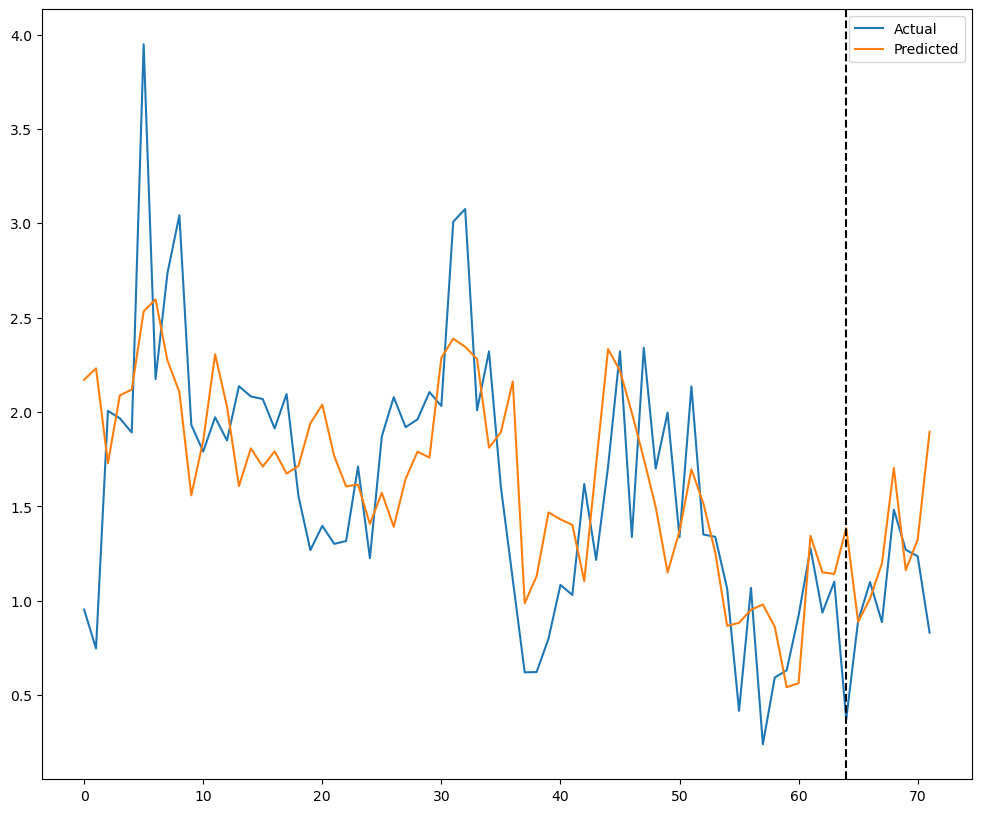

In [76]:
pred_in = results["pred_in_mean"] # In-sample (train)
pred_out = results["pred_mean"]   # OOS (test)

# Annualized in-sample
predict = np.concatenate((pred_in, pred_out), axis=0)
predict = DataTools.inverse_scaling(predict, y_mean, y_std) * 400

# Annualized OOS
real = np.concatenate((y_train, y_test), axis=0)
real = DataTools.inverse_scaling(real, y_mean, y_std) * 400

# Plot the results
plt.rcParams["figure.figsize"]= (12,10)
plt.plot(real, label='Actual')
plt.plot(predict, label='Predicted')
plt.axvline(x=(oos_pos+1), color='black', linestyle='--')
plt.legend()
plt.show()

OOS RMSE : 0.3877859507892834


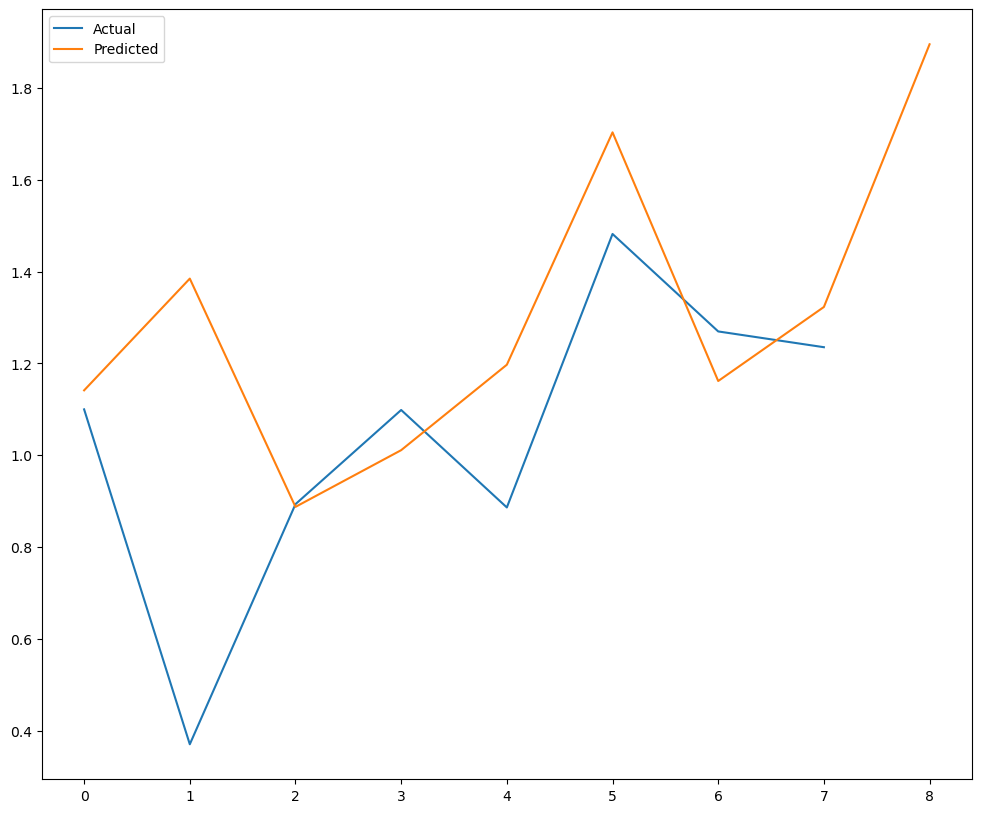

          Date  Realized  HNN4
66  2015-12-31       1.1   1.1
67  2016-03-31       0.4   1.4
68  2016-06-30       0.9   0.9
69  2016-09-30       1.1   1.0
70  2016-12-31       0.9   1.2
71  2017-03-31       1.5   1.7
72  2017-06-30       1.3   1.2
73  2017-09-30       1.2   1.3
74  2017-12-31       NaN   1.9


In [77]:
# Realized values
realized = y_test[:-1] # Remove the last value (2017Q4)
realized = np.append(realized, np.nan)
realized = DataTools.inverse_scaling(realized, y_mean, y_std) * 400

# Forecasted values
predicted = results["pred_mean"]
predicted = DataTools.inverse_scaling(predicted, y_mean, y_std) * 400

# Plot the results
print("OOS RMSE : " + str(math.sqrt(DataTools.MSE(realized, predicted)))) # RMSE
plt.rcParams["figure.figsize"]= (12,10)
plt.plot(realized, label='Actual')
plt.plot(predicted, label='Predicted')
plt.legend()
plt.show()

# Put realized and predicted values in a dataframe
df = pd.DataFrame({'Date':dates[-len(realized):],
                   'Realized': realized,
                   'HNN4': predicted})
df = df.round(1)
print(df)

In [78]:
df.to_csv('../data/predictions/HNN4.csv', index=False)

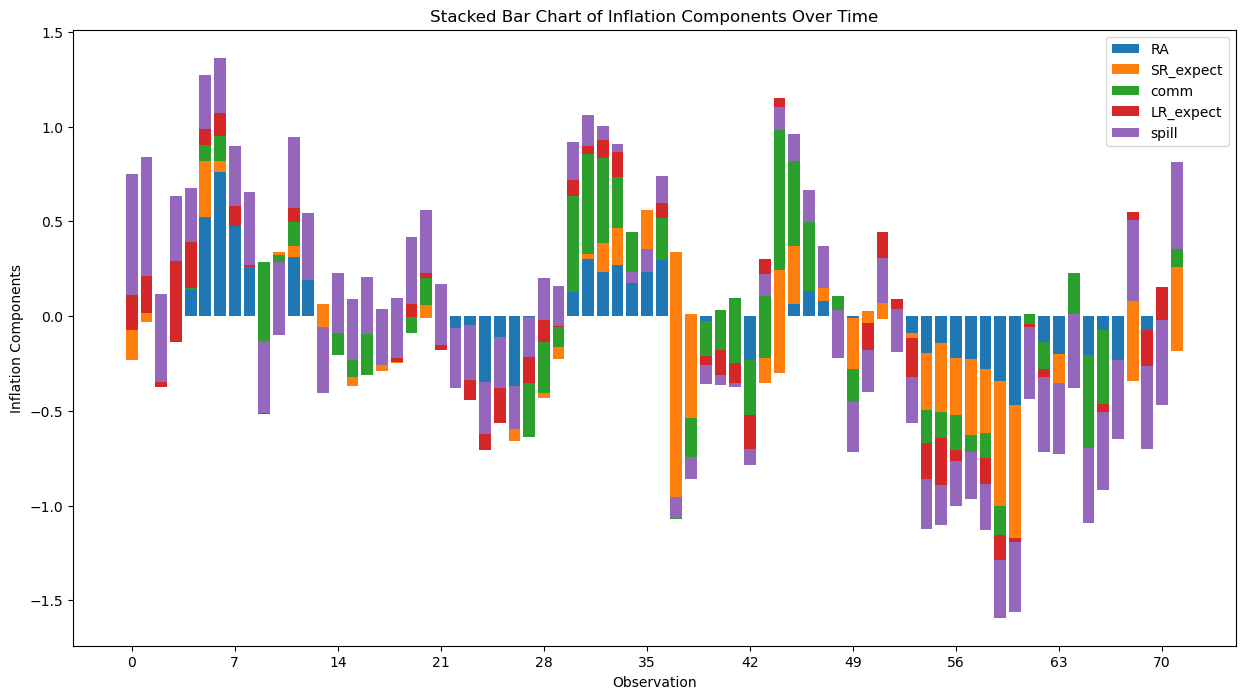

In [79]:
comps = np.vstack((results['part_pred_in_mean'], results['part_pred_mean']))

observations = len(comps)

components_names = ['RA', 'SR_expect', 'comm', 'LR_expect', 'spill']

# Creating the stacked bar chart
plt.figure(figsize=(15, 8))  # Adjust the figure size as needed

# Stacking bars for each component
bottom = np.zeros(observations)
for i in range(5):
    plt.bar(range(observations), comps[:, i], bottom=bottom, label=components_names[i])
    bottom += comps[:, i]

plt.xlabel('Observation')
plt.ylabel('Inflation Components')
plt.title('Stacked Bar Chart of Inflation Components Over Time')
plt.xticks(range(0, observations, max(1, observations // 10)))  # Adjust the x-axis ticks as needed
plt.legend()

plt.show()

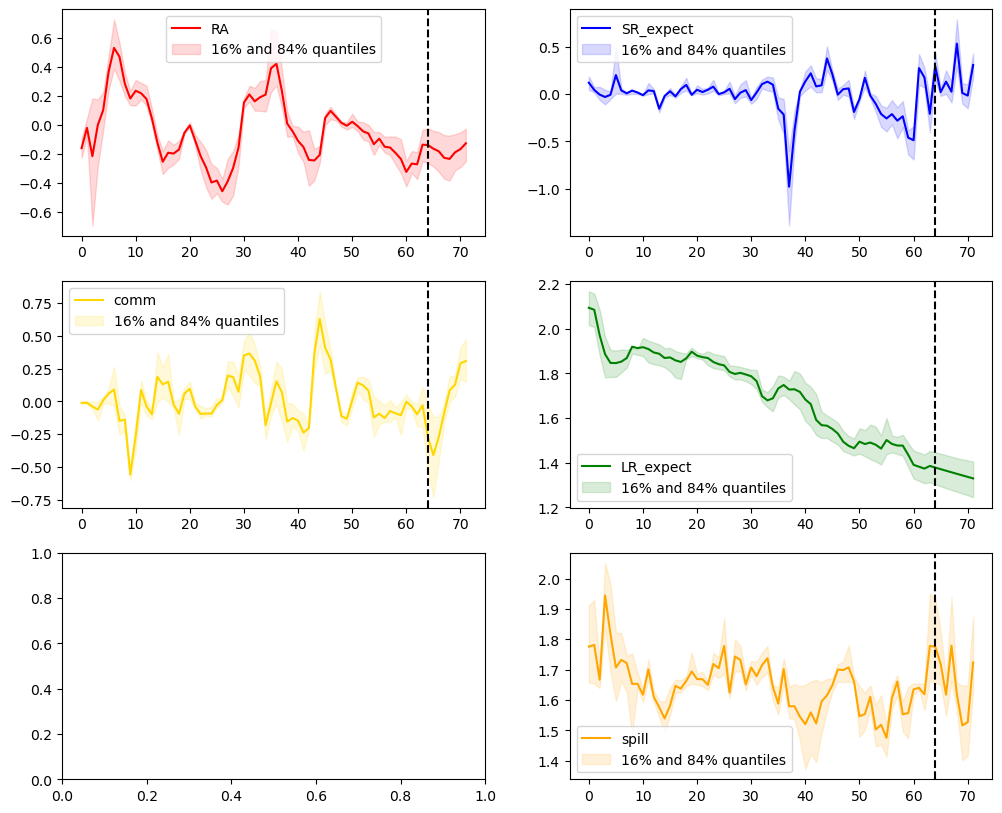

In [80]:
# Get all components
RA = np.concatenate((results['part_pred_in_mean'][:,0], results['part_pred_mean'][:,0]), axis=0)
RA = DataTools.inverse_scaling(RA, 0, y_std) * 400
RA_quantiles = np.concatenate((results["part_pred_in_ensemble"][:,0,:],results["part_pred_ensemble"][:,0,:]), axis=0)
RA_quantiles = np.nanquantile(RA_quantiles, [0.16, 0.84], axis=1)
RA_quantiles = DataTools.inverse_scaling(RA_quantiles, 0, y_std) * 400


SR_expect = np.concatenate((results['part_pred_in_mean'][:,1], results['part_pred_mean'][:,1]), axis=0)
SR_expect = DataTools.inverse_scaling(SR_expect, 0, y_std) * 400
SR_expect_quantiles = np.concatenate((results["part_pred_in_ensemble"][:,1,:],results["part_pred_ensemble"][:,1,:]), axis=0)
SR_expect_quantiles = np.nanquantile(SR_expect_quantiles, [0.16, 0.84], axis=1)
SR_expect_quantiles = DataTools.inverse_scaling(SR_expect_quantiles, 0, y_std) * 400

comm = np.concatenate((results['part_pred_in_mean'][:,2], results['part_pred_mean'][:,2]), axis=0)
comm = DataTools.inverse_scaling(comm, 0, y_std) * 400
comm_quantiles = np.concatenate((results["part_pred_in_ensemble"][:,2,:],results["part_pred_ensemble"][:,2,:]), axis=0)
comm_quantiles = np.nanquantile(comm_quantiles, [0.16, 0.84], axis=1)
comm_quantiles = DataTools.inverse_scaling(comm_quantiles, 0, y_std) * 400

LR_expect = np.concatenate((results['part_pred_in_mean'][:,4], results['part_pred_mean'][:,4]), axis=0)
LR_expect = DataTools.inverse_scaling(LR_expect, y_mean, y_std) * 400
LR_expect_quantiles = np.concatenate((results["part_pred_in_ensemble"][:,4,:],results["part_pred_ensemble"][:,4,:]), axis=0)
LR_expect_quantiles = np.nanquantile(LR_expect_quantiles, [0.16, 0.84], axis=1)
LR_expect_quantiles = DataTools.inverse_scaling(LR_expect_quantiles, y_mean, y_std) * 400

spill = np.concatenate((results['part_pred_in_mean'][:,3], results['part_pred_mean'][:,3]), axis=0)
spill = DataTools.inverse_scaling(spill, y_mean, y_std) * 400
spill_quantiles = np.concatenate((results["part_pred_in_ensemble"][:,3,:],results["part_pred_ensemble"][:,3,:]), axis=0)
spill_quantiles = np.nanquantile(spill_quantiles, [0.16, 0.84], axis=1)
spill_quantiles = DataTools.inverse_scaling(spill_quantiles, y_mean, y_std) * 400


# Plot a 2 by 2 grid of RA, SR_expect, comm, LR_expect
plt.rcParams["figure.figsize"]= (12,10)
fig, axes = plt.subplots(3, 2)
axes[0,0].plot(RA, label='RA', color='red')
axes[0,0].fill_between(range(len(RA_quantiles[0])), RA_quantiles[0], RA_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'red')

axes[0,1].plot(SR_expect, label='SR_expect', color='blue')
axes[0,1].fill_between(range(len(SR_expect_quantiles[0])), SR_expect_quantiles[0], SR_expect_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'blue')

axes[1,0].plot(comm, label='comm', color = 'gold')
axes[1,0].fill_between(range(len(comm_quantiles[0])), comm_quantiles[0], comm_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'gold')

axes[1,1].plot(LR_expect, label='LR_expect', color = 'green')
axes[1,1].fill_between(range(len(LR_expect_quantiles[0])), LR_expect_quantiles[0], LR_expect_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'green')

axes[2,1].plot(spill, label='spill', color = 'orange')
axes[2,1].fill_between(range(len(spill_quantiles[0])), spill_quantiles[0], spill_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'orange')

axes[0,0].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[0,1].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[1,0].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[1,1].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[2,1].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')

axes[0,0].legend()
axes[0,1].legend()
axes[1,0].legend()
axes[1,1].legend()
axes[2,1].legend()
plt.show()

### Gaps

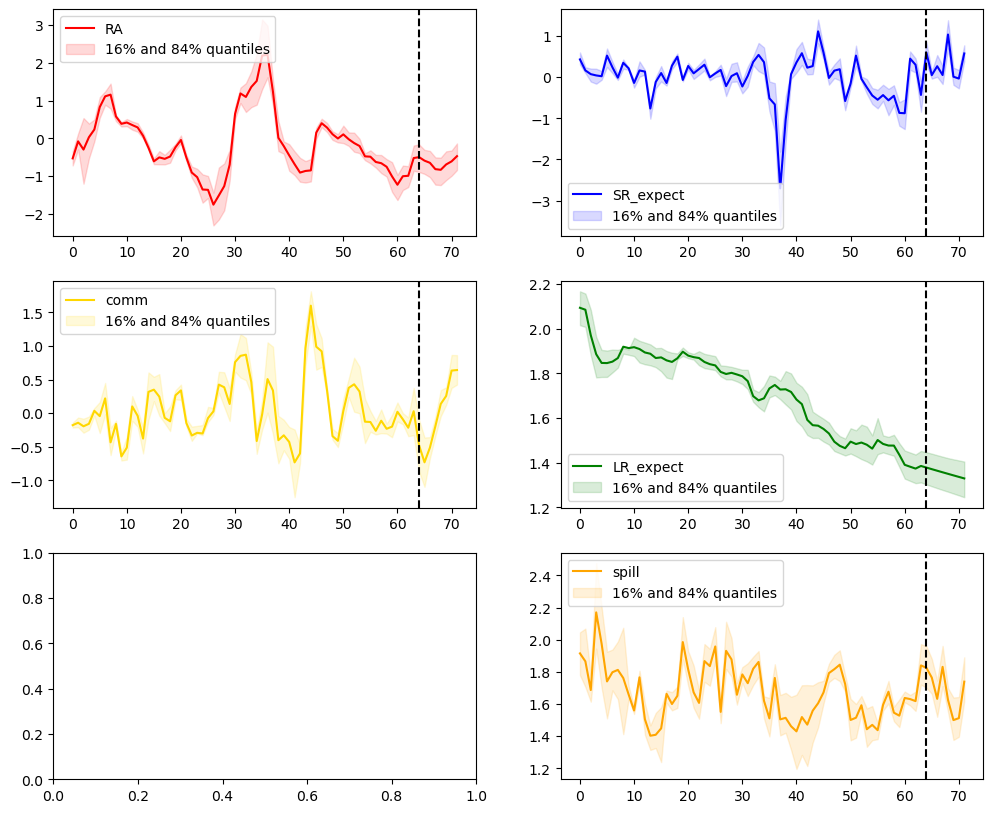

In [81]:
# Get all gaps
RA = np.concatenate((results['gaps_in_mean'][:,0], results['gaps_mean'][:,0]), axis=0)
RA = DataTools.inverse_scaling(RA, 0, y_std) * 400
RA_quantiles = np.concatenate((results["gaps_in_ensemble"][:,0,:],results["gaps_ensemble"][:,0,:]), axis=0)
RA_quantiles = np.nanquantile(RA_quantiles, [0.16, 0.84], axis=1)
RA_quantiles = DataTools.inverse_scaling(RA_quantiles, 0, y_std) * 400

SR_expect = np.concatenate((results['gaps_in_mean'][:,1], results['gaps_mean'][:,1]), axis=0)
SR_expect = DataTools.inverse_scaling(SR_expect, 0, y_std) * 400
SR_expect_quantiles = np.concatenate((results["gaps_in_ensemble"][:,1,:],results["gaps_ensemble"][:,1,:]), axis=0)
SR_expect_quantiles = np.nanquantile(SR_expect_quantiles, [0.16, 0.84], axis=1)
SR_expect_quantiles = DataTools.inverse_scaling(SR_expect_quantiles, 0, y_std) * 400

comm = np.concatenate((results['gaps_in_mean'][:,2], results['gaps_mean'][:,2]), axis=0)
comm = DataTools.inverse_scaling(comm, 0, y_std) * 400
comm_quantiles = np.concatenate((results["gaps_in_ensemble"][:,2,:],results["gaps_ensemble"][:,2,:]), axis=0)
comm_quantiles = np.nanquantile(comm_quantiles, [0.16, 0.84], axis=1)
comm_quantiles = DataTools.inverse_scaling(comm_quantiles, 0, y_std) * 400

LR_expect = np.concatenate((results['gaps_in_mean'][:,4], results['gaps_mean'][:,4]), axis=0)
LR_expect = DataTools.inverse_scaling(LR_expect, y_mean, y_std) * 400
LR_expect_quantiles = np.concatenate((results["gaps_in_ensemble"][:,4,:],results["gaps_ensemble"][:,4,:]), axis=0)
LR_expect_quantiles = np.nanquantile(LR_expect_quantiles, [0.16, 0.84], axis=1)
LR_expect_quantiles = DataTools.inverse_scaling(LR_expect_quantiles, y_mean, y_std) * 400

spill = np.concatenate((results['gaps_in_mean'][:,3], results['gaps_mean'][:,3]), axis=0)
spill = DataTools.inverse_scaling(spill, y_mean, y_std) * 400
spill_quantiles = np.concatenate((results["gaps_in_ensemble"][:,3,:],results["gaps_ensemble"][:,3,:]), axis=0)
spill_quantiles = np.nanquantile(spill_quantiles, [0.16, 0.84], axis=1)
spill_quantiles = DataTools.inverse_scaling(spill_quantiles, y_mean, y_std) * 400



# Plot a 3 by 2 grid of RA, SR_expect, comm, LR_expect, spill
plt.rcParams["figure.figsize"]= (12,10)
fig, axes = plt.subplots(3, 2)
axes[0,0].plot(RA, label='RA', color='red')
axes[0,0].fill_between(range(len(RA_quantiles[0])), RA_quantiles[0], RA_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'red')

axes[0,1].plot(SR_expect, label='SR_expect', color='blue')
axes[0,1].fill_between(range(len(SR_expect_quantiles[0])), SR_expect_quantiles[0], SR_expect_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'blue')

axes[1,0].plot(comm, label='comm', color = 'gold')
axes[1,0].fill_between(range(len(comm_quantiles[0])), comm_quantiles[0], comm_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'gold')

axes[1,1].plot(LR_expect, label='LR_expect', color = 'green')
axes[1,1].fill_between(range(len(LR_expect_quantiles[0])), LR_expect_quantiles[0], LR_expect_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'green')

axes[2,1].plot(spill, label='spill', color = 'orange')
axes[2,1].fill_between(range(len(spill_quantiles[0])), spill_quantiles[0], spill_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'orange')

axes[0,0].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[0,1].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[1,0].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[1,1].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[2,1].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[0,0].legend()
axes[0,1].legend()
axes[1,0].legend()
axes[1,1].legend()
axes[2,1].legend()
plt.show()

## Trends (Time-varying coefficients)

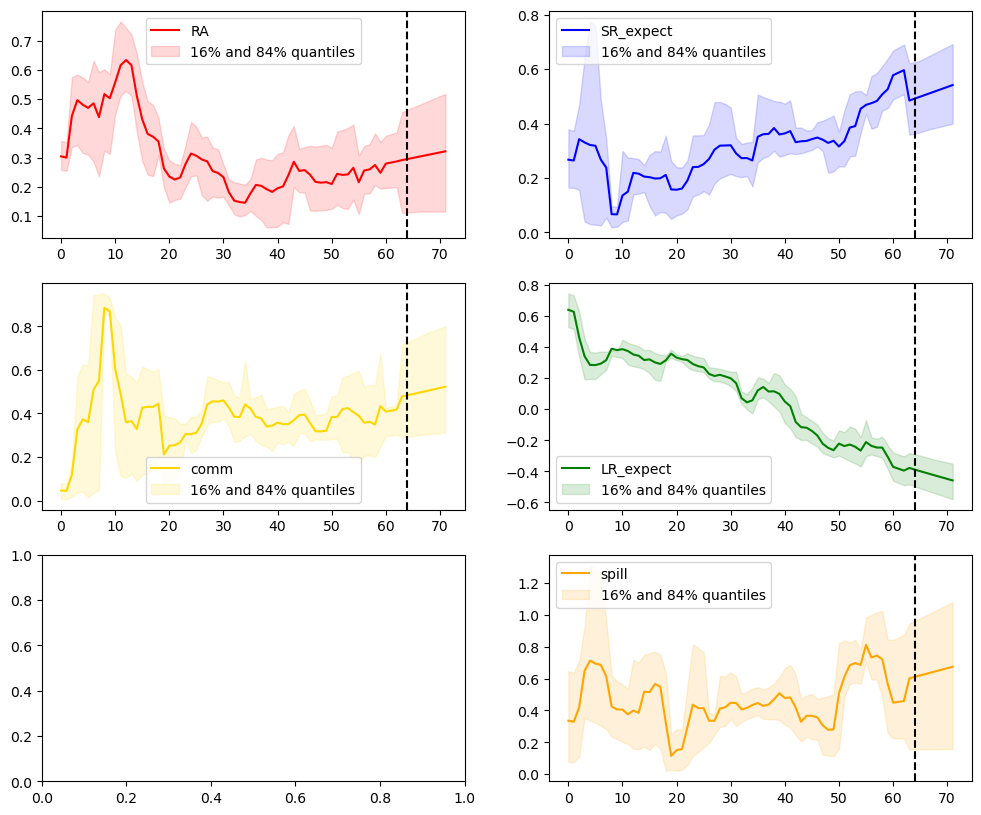

In [82]:
RA = np.concatenate((results['trends_in_mean'][:,0], results['trends_mean'][:,0]), axis=0)
RA_quantiles =  np.concatenate((results["trends_in_ensemble"][:,0,:],results["trends_ensemble"][:,0,:]), axis=0)
RA_quantiles = np.nanquantile(RA_quantiles, [0.16, 0.84], axis=1)

SR_expect = np.concatenate((results['trends_in_mean'][:,1], results['trends_mean'][:,1]), axis=0)
SR_expect_quantiles = np.concatenate((results["trends_in_ensemble"][:,1,:],results["trends_ensemble"][:,1,:]), axis=0)
SR_expect_quantiles = np.nanquantile(SR_expect_quantiles, [0.16, 0.84], axis=1)

comm = np.concatenate((results['trends_in_mean'][:,2], results['trends_mean'][:,2]), axis=0)
comm_quantiles = np.concatenate((results["trends_in_ensemble"][:,2,:],results["trends_ensemble"][:,2,:]), axis=0)
comm_quantiles = np.nanquantile(comm_quantiles, [0.16, 0.84], axis=1)

LR_expect = np.concatenate((results['part_pred_in_mean'][:,4], results['part_pred_mean'][:,4]), axis=0)
LR_expect_quantiles = np.concatenate((results["part_pred_in_ensemble"][:,4,:],results["part_pred_ensemble"][:,4,:]), axis=0)
LR_expect_quantiles = np.nanquantile(LR_expect_quantiles, [0.16, 0.84], axis=1)

spill = np.concatenate((results['trends_in_mean'][:,3], results['trends_mean'][:,3]), axis=0)
spill_quantiles = np.concatenate((results["trends_in_ensemble"][:,3,:],results["trends_ensemble"][:,3,:]), axis=0)
spill_quantiles = np.nanquantile(spill_quantiles, [0.16, 0.84], axis=1)

# Plot a 2 by 2 grid of RA, SR_expect, comm, LR_expect, spill
plt.rcParams["figure.figsize"]= (12,10)
fig, axes = plt.subplots(3, 2)
axes[0,0].plot(RA, label='RA', color='red')
axes[0,0].fill_between(range(len(RA_quantiles[0])), RA_quantiles[0], RA_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'red')

axes[0,1].plot(SR_expect, label='SR_expect', color='blue')
axes[0,1].fill_between(range(len(SR_expect_quantiles[0])), SR_expect_quantiles[0], SR_expect_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'blue')

axes[1,0].plot(comm, label='comm', color = 'gold')
axes[1,0].fill_between(range(len(comm_quantiles[0])), comm_quantiles[0], comm_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'gold')

axes[1,1].plot(LR_expect, label='LR_expect', color = 'green')
axes[1,1].fill_between(range(len(LR_expect_quantiles[0])), LR_expect_quantiles[0], LR_expect_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'green')

axes[2,1].plot(spill, label='spill', color = 'orange')
axes[2,1].fill_between(range(len(spill_quantiles[0])), spill_quantiles[0], spill_quantiles[1], alpha=0.15, label='16% and 84% quantiles', color = 'orange')

axes[0,0].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[0,1].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[1,0].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[1,1].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')
axes[2,1].axvline(x=(X_train.shape[0]+1), color='black', linestyle='--')

axes[0,0].legend()
axes[0,1].legend()
axes[1,0].legend()
axes[1,1].legend()
axes[2,1].legend()
plt.show()

In [83]:
# save model
torch.save(results, '../models/HNN4.pt')